Vasmos a cargar el dataset de AirBnB descargado de [aquí](https://public.opendatasoft.com/explore/dataset/airbnb-listings/export/?disjunctive.host_verifications&disjunctive.amenities&disjunctive.features&q=Madrid&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQ09VTlQiLCJ5QXhpcyI6Imhvc3RfbGlzdGluZ3NfY291bnQiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiJyYW5nZS1jdXN0b20ifV0sInhBeGlzIjoiY2l0eSIsIm1heHBvaW50cyI6IiIsInRpbWVzY2FsZSI6IiIsInNvcnQiOiIiLCJzZXJpZXNCcmVha2Rvd24iOiJyb29tX3R5cGUiLCJjb25maWciOnsiZGF0YXNldCI6ImFpcmJuYi1saXN0aW5ncyIsIm9wdGlvbnMiOnsiZGlzanVuY3RpdmUuaG9zdF92ZXJpZmljYXRpb25zIjp0cnVlLCJkaXNqdW5jdGl2ZS5hbWVuaXRpZXMiOnRydWUsImRpc2p1bmN0aXZlLmZlYXR1cmVzIjp0cnVlfX19XSwidGltZXNjYWxlIjoiIiwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D&location=16,41.38377,2.15774&basemap=jawg.streets)

![](descargar.png)

In [334]:
airbnb<-read.csv('airbnb-listings.csv',sep = ';')
options(repr.plot.height=4,repr.plot.width=6,repr.plot.res = 300)


Vamos a quedarnos con las columnas de mayor interés:

'City','Room.Type','Neighbourhood','Accommodates','Bathrooms','Bedrooms','Beds','Price','Square.Feet','Guests.Included','Extra.People','Review.Scores.Rating','Latitude', 'Longitude'

In [335]:
airbnb <- airbnb[c('City','Room.Type','Neighbourhood','Accommodates','Bathrooms','Bedrooms','Beds','Price','Square.Feet','Guests.Included','Extra.People','Review.Scores.Rating','Latitude', 'Longitude')]


Nos quedarmos solo con las entradas de Madrid para Room.Type=="Entire home/apt" y cuyo barrio (Neighbourhood) no está vacio ''
Podemos eliminar las siguientes columnas que ya no son necesarias:
"Room.Type",'City'

Llama a nuevo dataframe df_madrid.

In [336]:
library(dplyr)
airbnb |> filter(City=='Madrid', Room.Type=='Entire home/apt', Neighbourhood != '') |> select(-Room.Type,-City) -> df_madrid


Crea una nueva columna llamada Square.Meters a partir de Square.Feet. Recuerda que un pie cuadrado son 0.092903 metros cuadrados.

In [337]:
metrosPies <-0.092903
df_madrid$Square.Meters <- df_madrid$Square.Feet * metrosPies

¿Que porcentaje de los apartamentos no muestran los metros cuadrados? Es decir, ¿cuantos tienen NA en Square.Meters?

In [338]:
naValues <- sum(is.na(df_madrid$Square.Meters))
totalValues <- length(df_madrid$Square.Meters)
naPorcent <- (naValues/totalValues)*100

paste('El porcentaje de los apartamentos que no muestran los metros cuadrados es: ',round(naPorcent,2),'%')

[1] "El porcentaje de los apartamentos que no muestran los metros cuadrados es:  93.8 %"

De todos los apartamentos que tienen un valor de metros cuadrados diferente de NA 
¿Que porcentaje de los apartamentos tienen 0 metros cuadrados?

In [339]:
zeroValues <- length(which(df_madrid$Square.Meters==0))
valuesSinNa <- sum(!is.na(df_madrid$Square.Meters))
zeroPorcent <- (zeroValues/valuesSinNa)*100
paste('El porcentaje de los apartamentos que con valor 0 en metros cuadrados diferentes de NA es: ',round(zeroPorcent,2),'%')

[1] "El porcentaje de los apartamentos que con valor 0 en metros cuadrados diferentes de NA es:  36.89 %"

Reemplazar todos los 0m^2 por NA 

In [340]:
df_madrid$Square.Meters[df_madrid$Square.Meters==0] <- NA

Son muchos, vamos a intentar crear un modelo que nos prediga cuantos son los metros cuadrados en función del resto de variables para tratar de rellenar esos NA. Pero **antes de crear el modelo** vamos a hacer:
* pintar el histograma de los metros cuadrados y ver si tenemos que filtrar algún elemento más.
* crearemos una variable sintética nueva basada en la similitud entre barrios que usaremos en nuestro modelo.

Pinta el histograma de los metros cuadrados y ver si tenemos que filtrar algún elemento más

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 5382 rows containing non-finite values (stat_bin).”


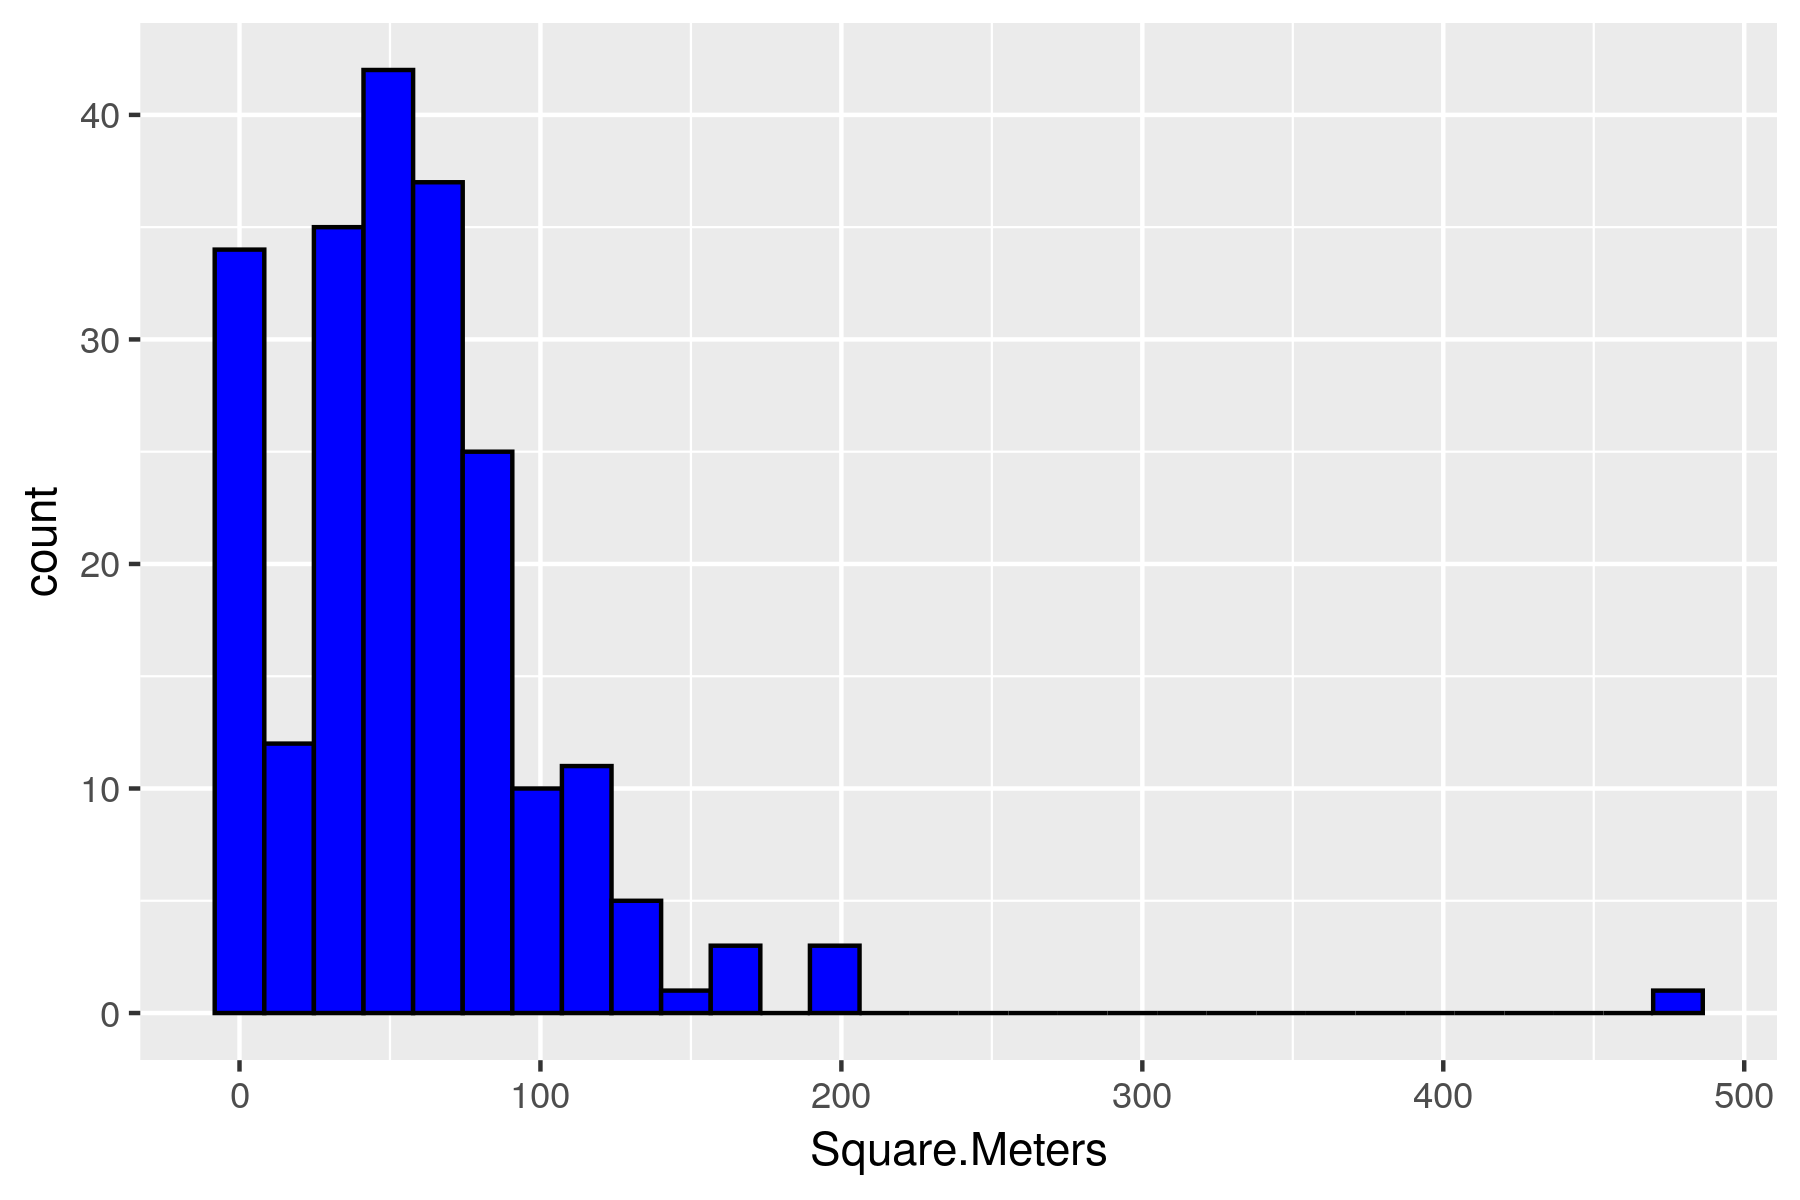

In [341]:
library(ggplot2)
options(repr.plot.height=4,repr.plot.width=6)

ggplot(data =df_madrid, aes(x=Square.Meters))+
geom_histogram(fill='blue', color='black')


Asigna el valor NA a la columna Square.Meters de los apartamentos que tengan menos de 20 m^2

In [342]:
df_madrid$Square.Meters[df_madrid$Square.Meters<20] <- NA

Existen varios Barrios que todas sus entradas de Square.Meters son NA, vamos a eliminar del dataset todos los pisos que pertenecen a estos barrios.

In [343]:
#Realizamos el agrupamiento por barrios y almacenamos en un vector el nombre de los Barrios que tienen todo NA en Square.Meters
df_madrid |> group_by(Neighbourhood) |> 
            summarise(n=sum(!is.na(Square.Meters))) |> 
            filter(n==0) |> pull(Neighbourhood) ->naNeighbourhood
#Eliminamos todas las entradas que tengan como barrio alguno de los contenidos en el vector naNeighbourhood
df_madrid <- df_madrid[!df_madrid$Neighbourhood %in% naNeighbourhood,]


El barrio parece ser un indicador importante para los metros cuadrados de un apartamento.

Vamos a agrupar los barrios por metros cuadrados. Podemos usar una matriz de similaridad de Tukey tal y como hicimos en el curso de estadística:

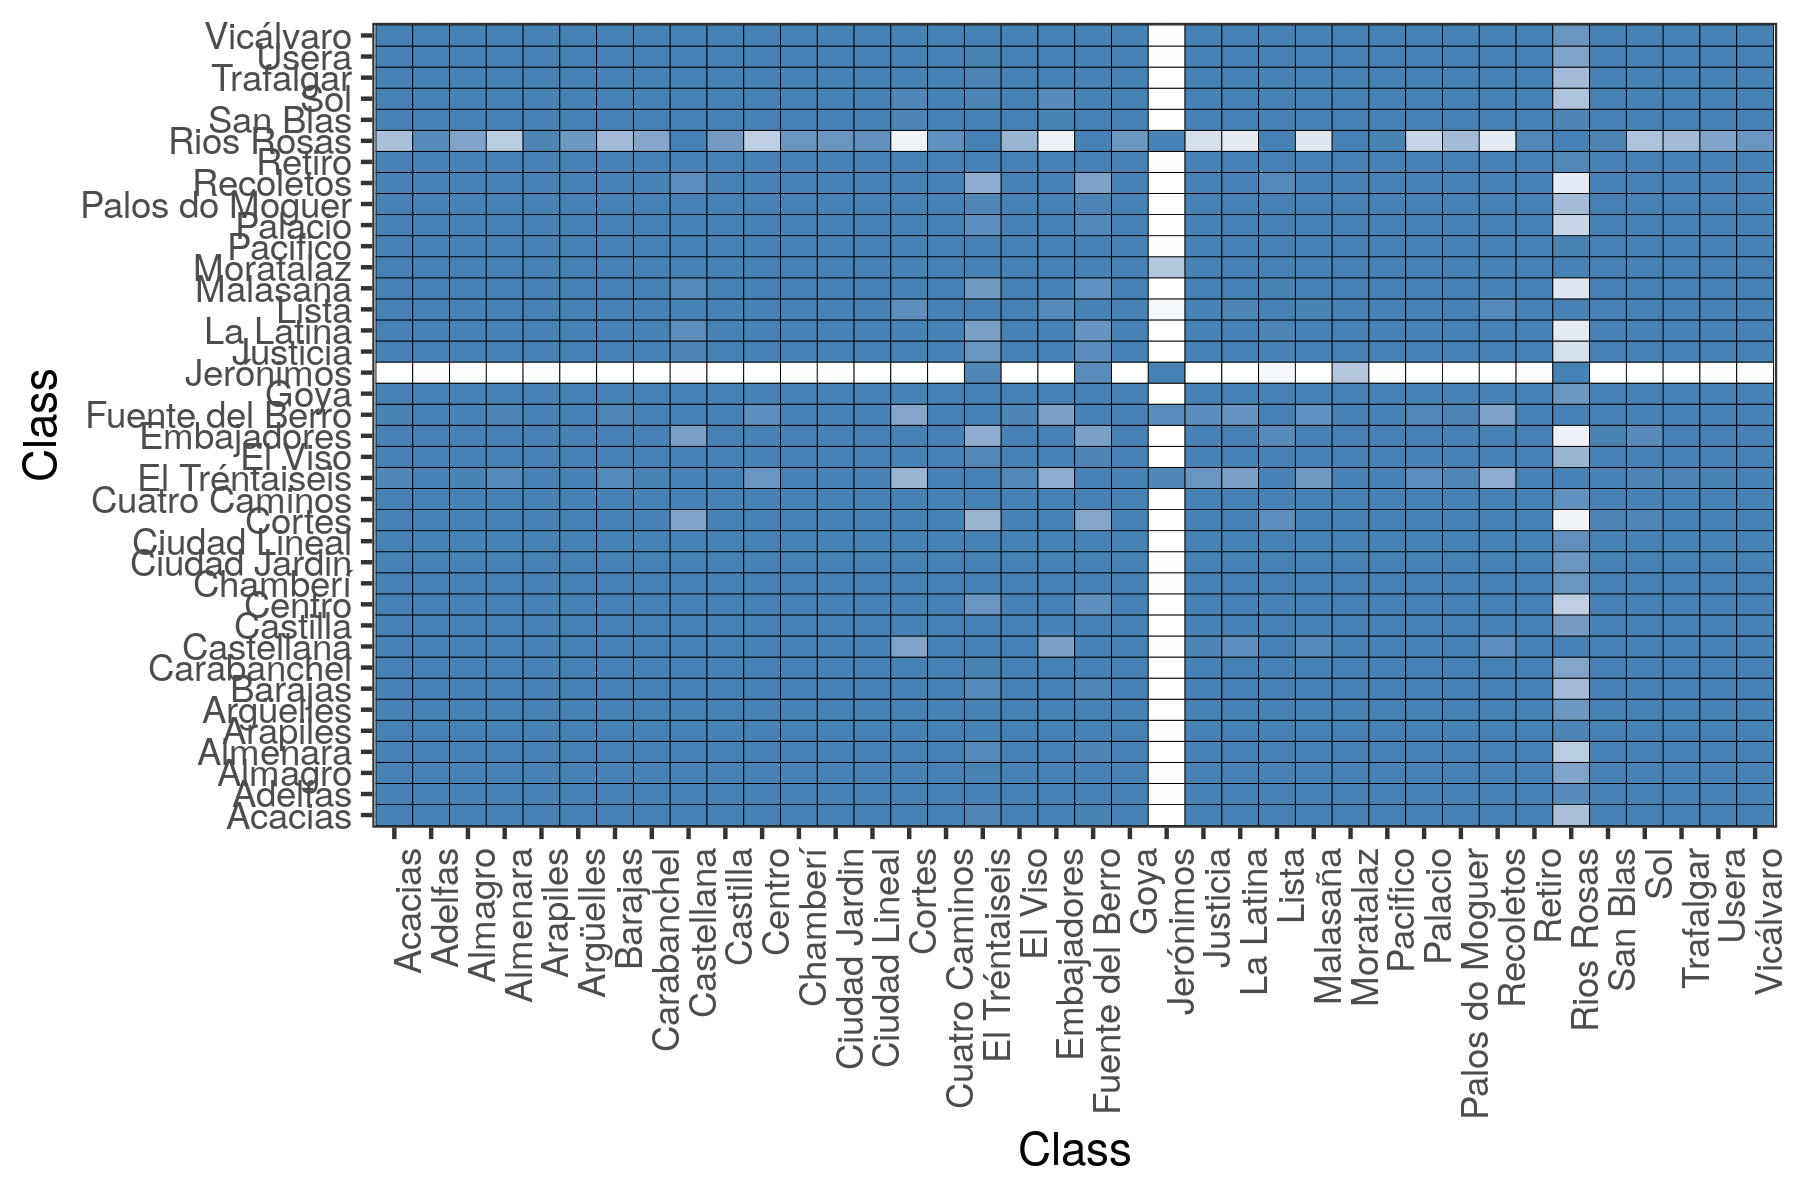

In [344]:
tky<-TukeyHSD(aov( formula=Square.Meters~Neighbourhood, data=df_madrid ))
tky.result<-data.frame(tky$Neighbourhood)
cn <-sort(unique(df_madrid$Neighbourhood))
resm <- matrix(NA, length(cn),length(cn))
rownames(resm) <- cn
colnames(resm) <- cn
resm[lower.tri(resm) ] <- round(tky.result$p.adj,4)
resm[upper.tri(resm) ] <- t(resm)[upper.tri(resm)] 
diag(resm) <- 1
library(ggplot2)
library(reshape2)
dfResm <- melt(resm)
ggplot(dfResm, aes(x=Var1, y=Var2, fill=value))+
  geom_tile(colour = "black")+
  scale_fill_gradient(low = "white",high = "steelblue")+
  ylab("Class")+xlab("Class")+theme_bw()+
  theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position="none")

Usando como variable de distancia: 1-resm
Dibuja un dendrograma de los diferentes barrios.


[1] "Visualizamos el dendrograma y marcamos los posibles valores de corte"

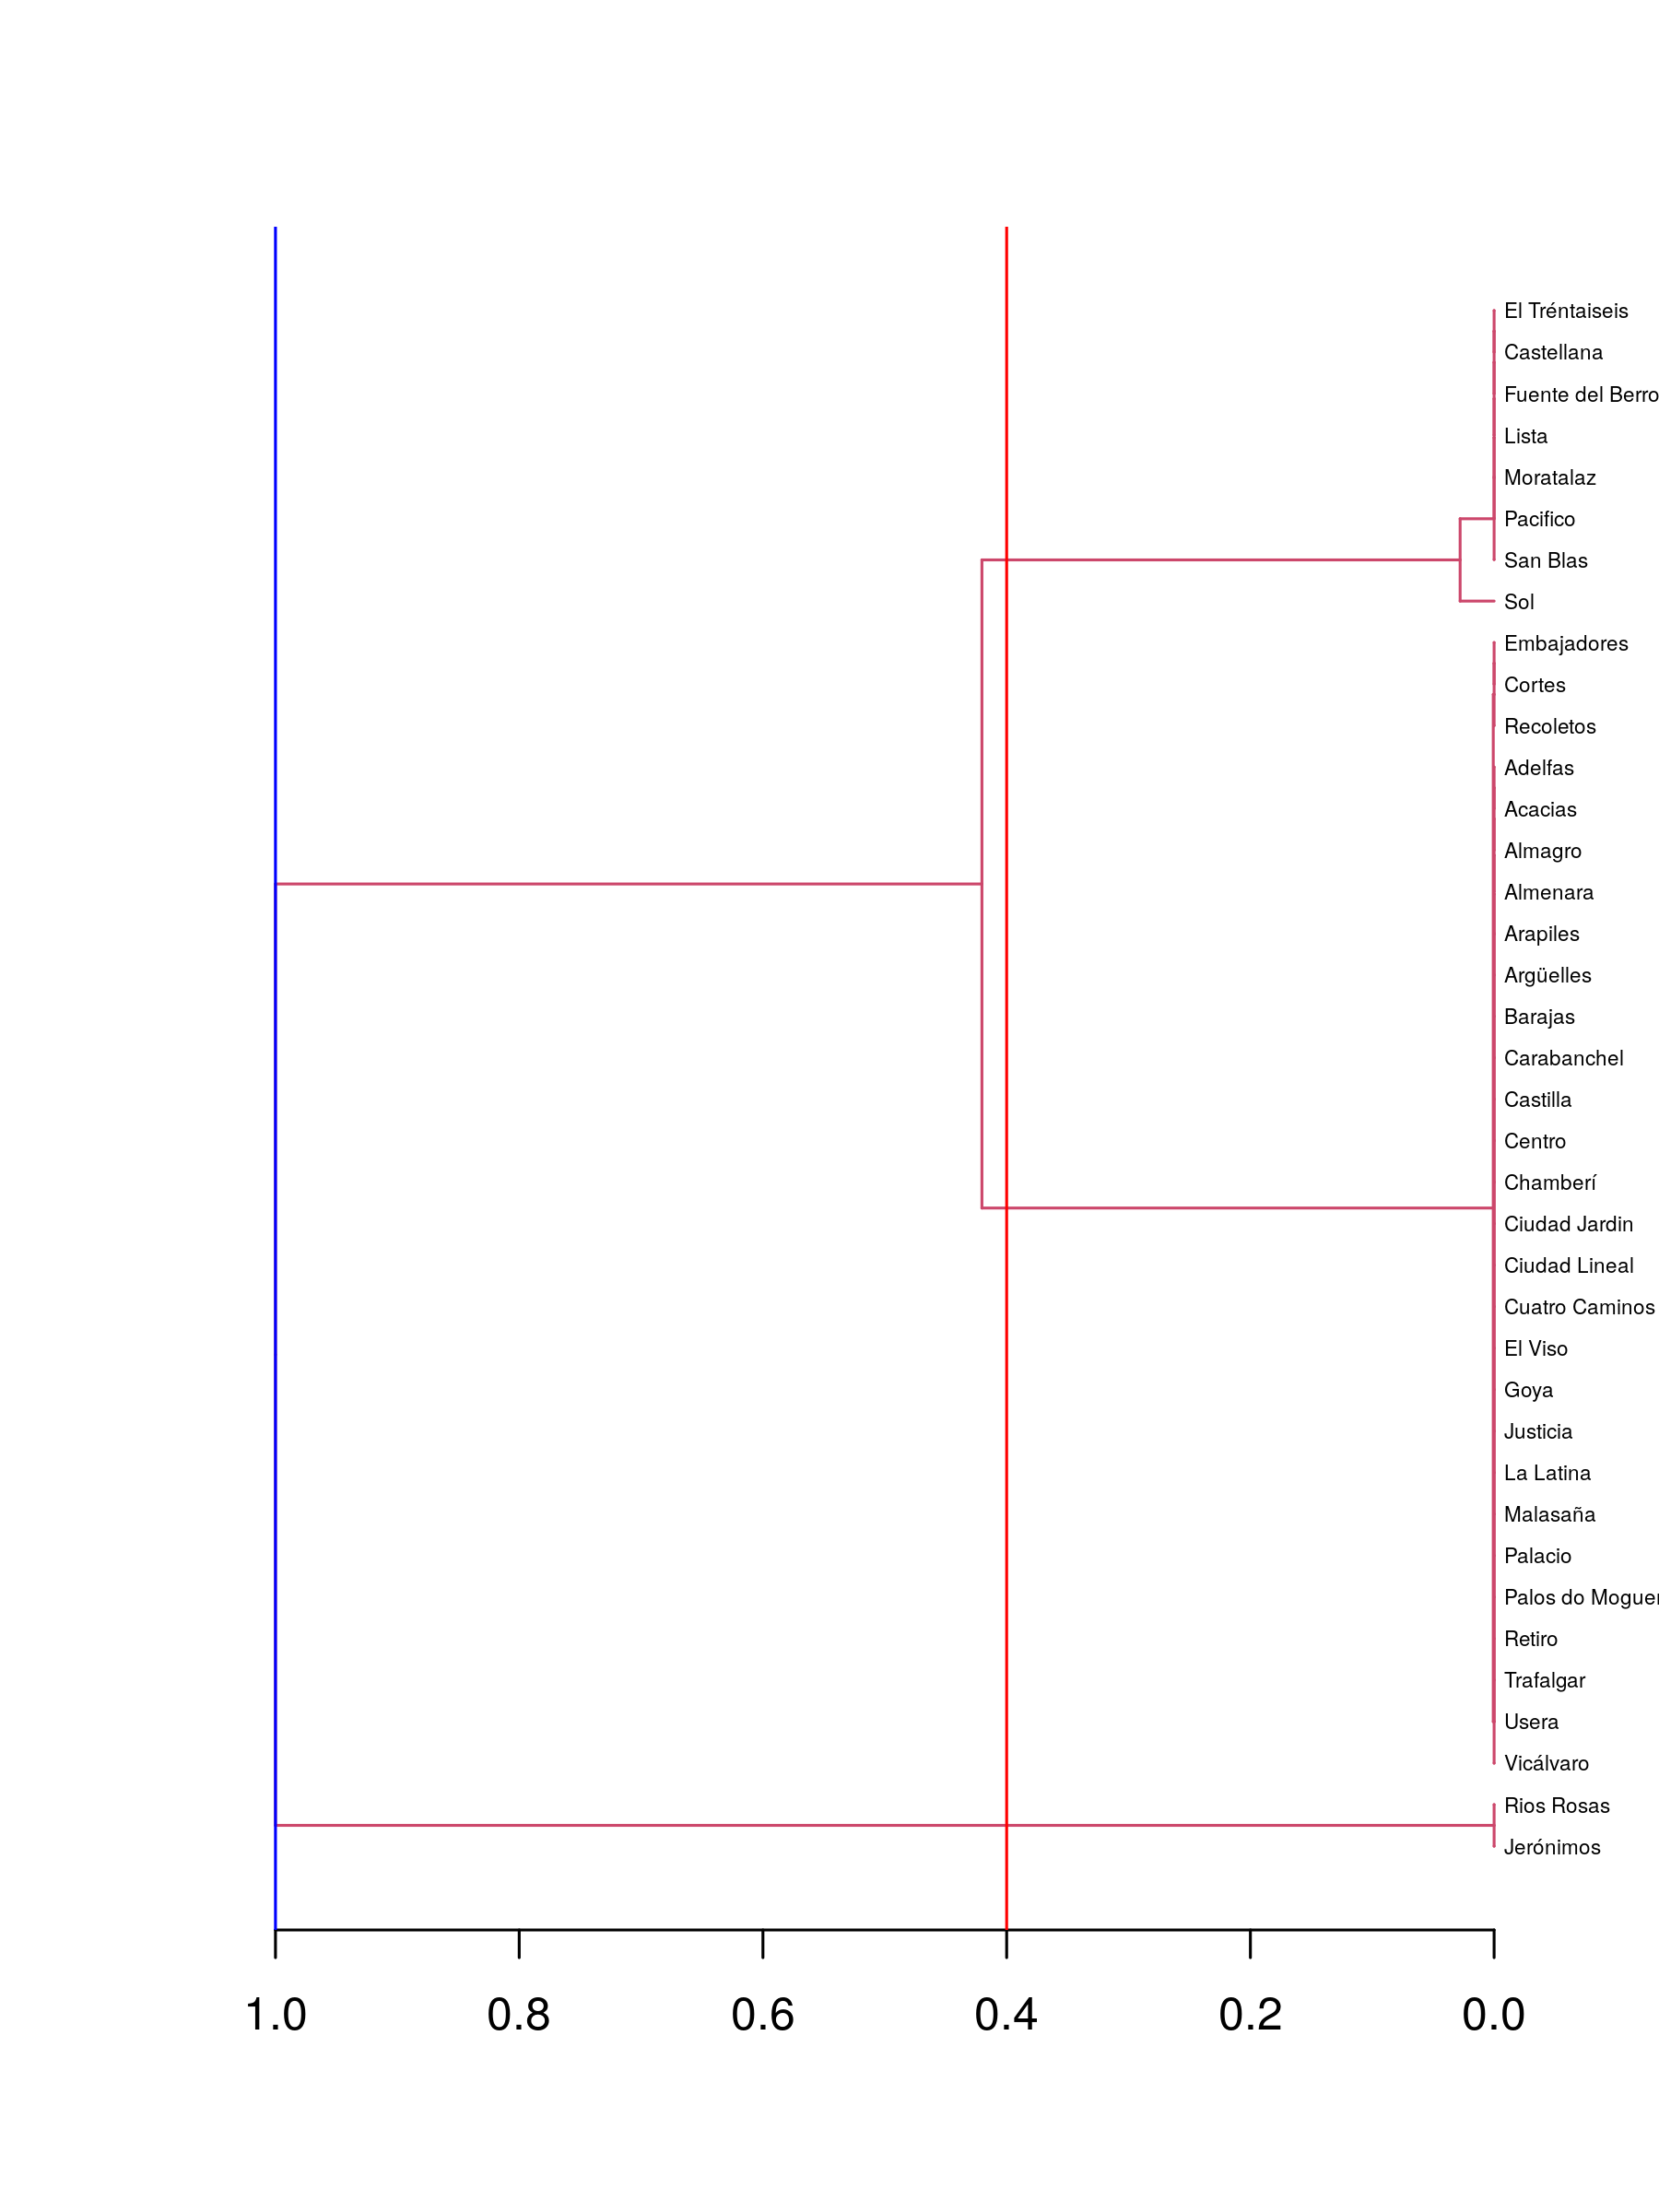

In [345]:
library(dendextend)
options(repr.plot.height=8,repr.plot.width=6,repr.plot.res = 300)
paste('Visualizamos el dendrograma y marcamos los posibles valores de corte')

Neighbourhood.dist <- as.dist((1-abs(resm)))
hc <- hclust(Neighbourhood.dist, method = 'complete')
hcd <- as.dendrogram(hc)
hcd<-set(hcd,"labels_cex", 0.45) 
plot(color_branches(hcd,h=2.5),horiz=TRUE,cex=0)
abline(v=0.4,col="red")
abline(v=1,col="blue")




[1] "######################################################################################################################"
[1] "Realizando el corte en h =  1 , obtenemos , 2  clusters, con un silhouette medio igual a  0.922893068654031"
[1] "-----------------------------------------------------------------------------------------------------------------"
[1] "Realizando el corte en h =  0.4 , obtenemos , 3  clusters, con un silhouette medio igual a  0.910373397934138"
[1] "-----------------------------------------------------------------------------------------------------------------"
[1] "######################################################################################################################"


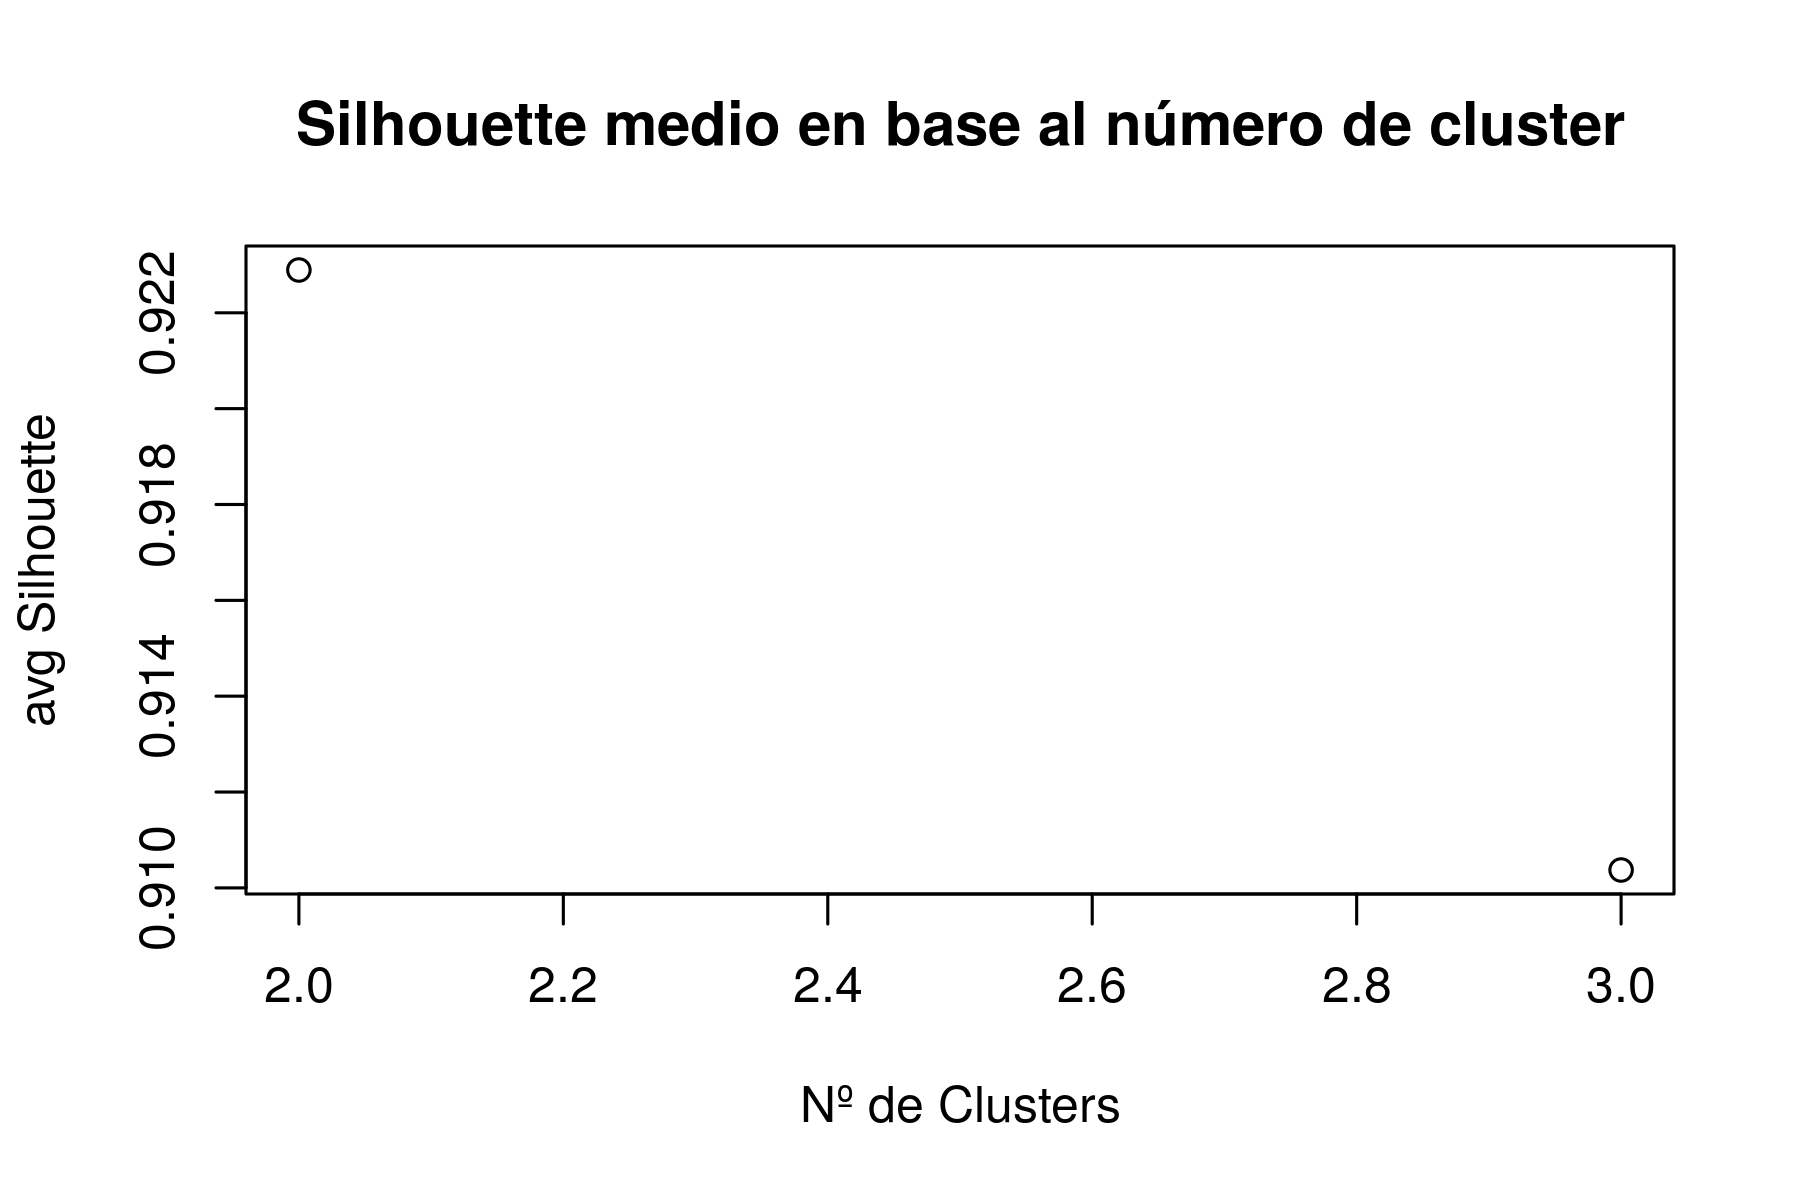

In [346]:
#Vamos a realizar el cálculo del silhouette medio en base al corte indicado en el paso anterior
library(cluster)
sil <- c() #variable para almacenar el silhouette medio
cluster <- c() #variable para almacenar el numero de clusters
rango <- c(1,0.4) #valores de h
print('######################################################################################################################')
for (k in rango){
    cl <- cutree_1h.dendrogram(hcd,h=k)
    ss<-silhouette(cl, Neighbourhood.dist)
    print(paste('Realizando el corte en h = ',k,', obtenemos ,',max(cl),' clusters, con un silhouette medio igual a ', mean(ss[, "sil_width"])))
    print('-----------------------------------------------------------------------------------------------------------------')
    sil<-c(mean(ss[, "sil_width"]),sil)    
    cluster <- c(max(cl),cluster)    
}
print('######################################################################################################################')
options(repr.plot.height=4,repr.plot.width=6,repr.plot.res = 300)
plot(x=cluster,y=sil,  xlab ='Nº de Clusters',ylab='avg Silhouette', main='Silhouette medio en base al número de cluster'  )

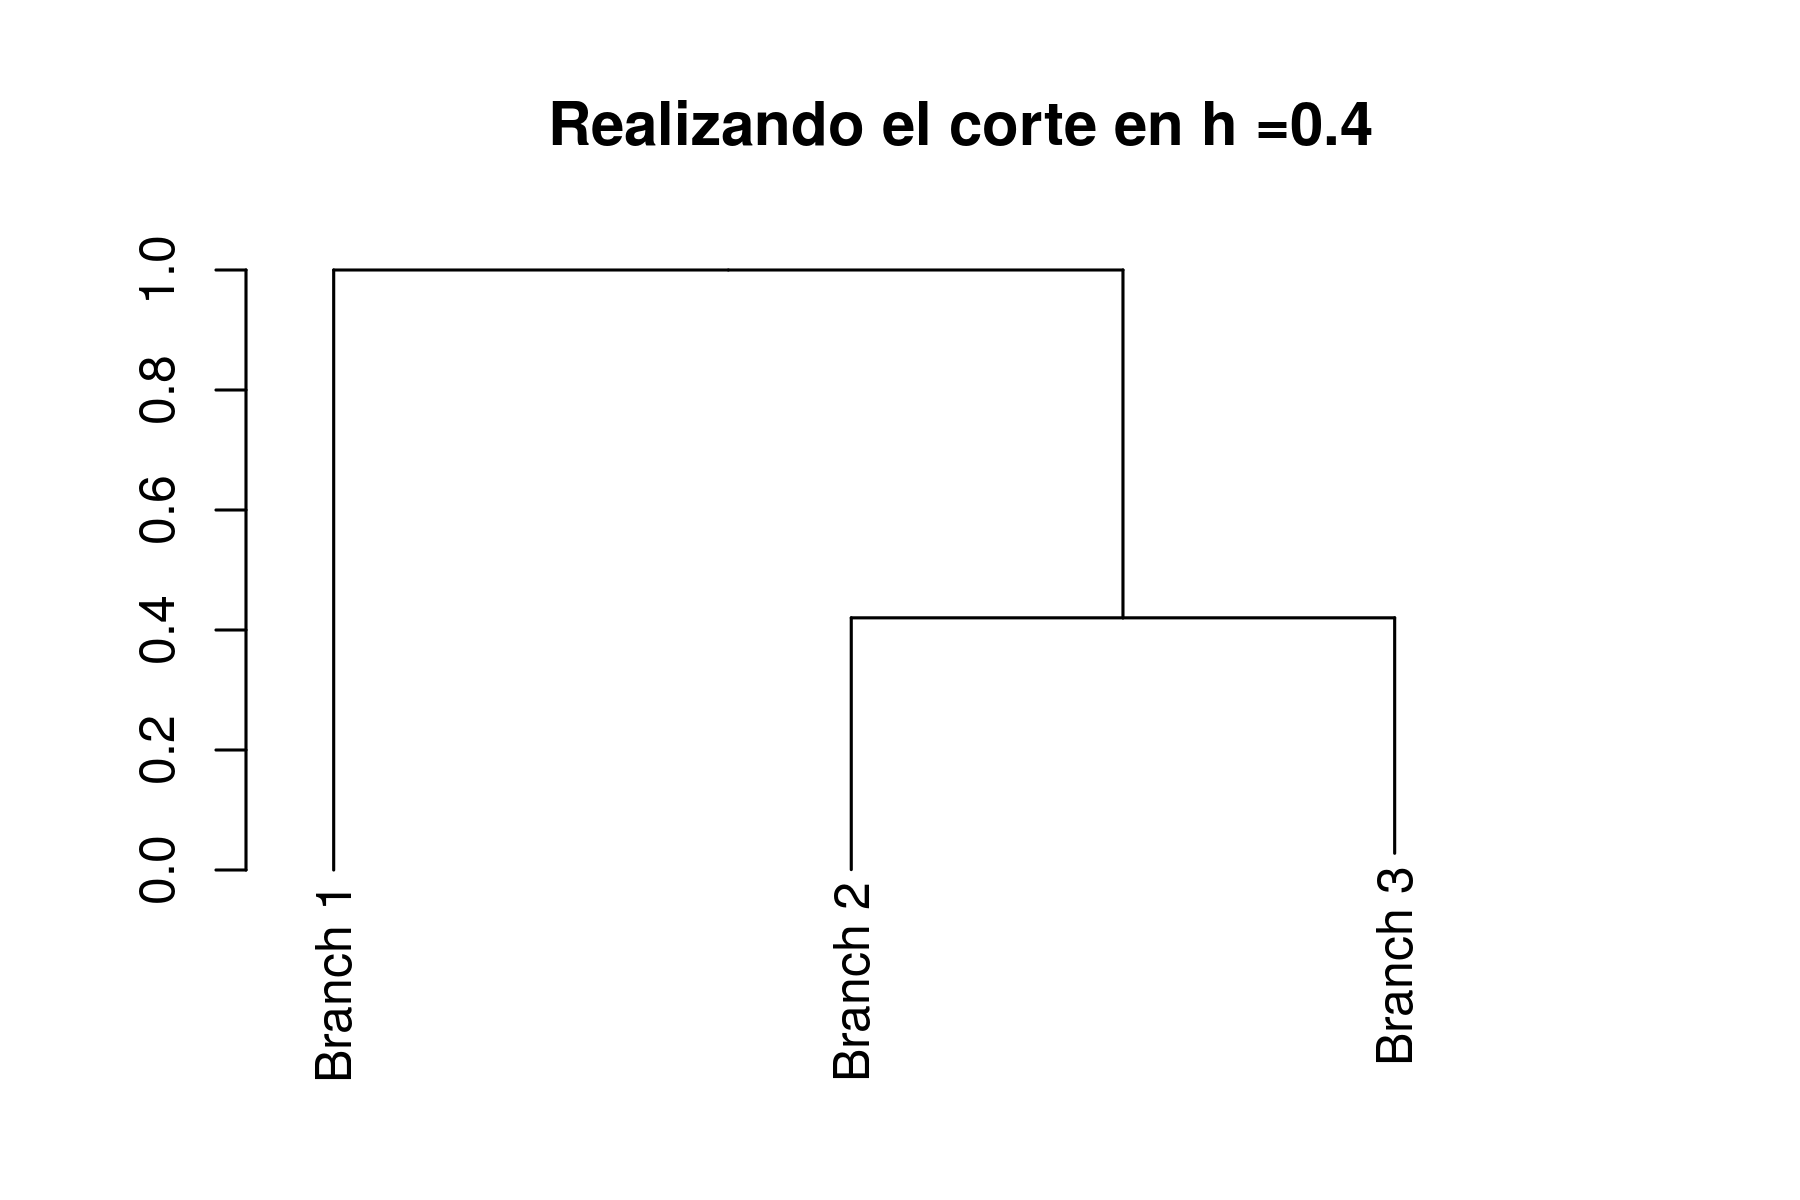

In [347]:
#En base al apartado anterior obtenemos un silhouette medio similar, por lo que optamos por generar 3 clusters ya que 
#de forma visual parece mejor opción
plot(cut(hcd, h = 0.4)$upper, main = "Realizando el corte en h =0.4", cex=1)


¿Que punto de corte sería el aconsejable?, ¿cuantos clusters aparecen?

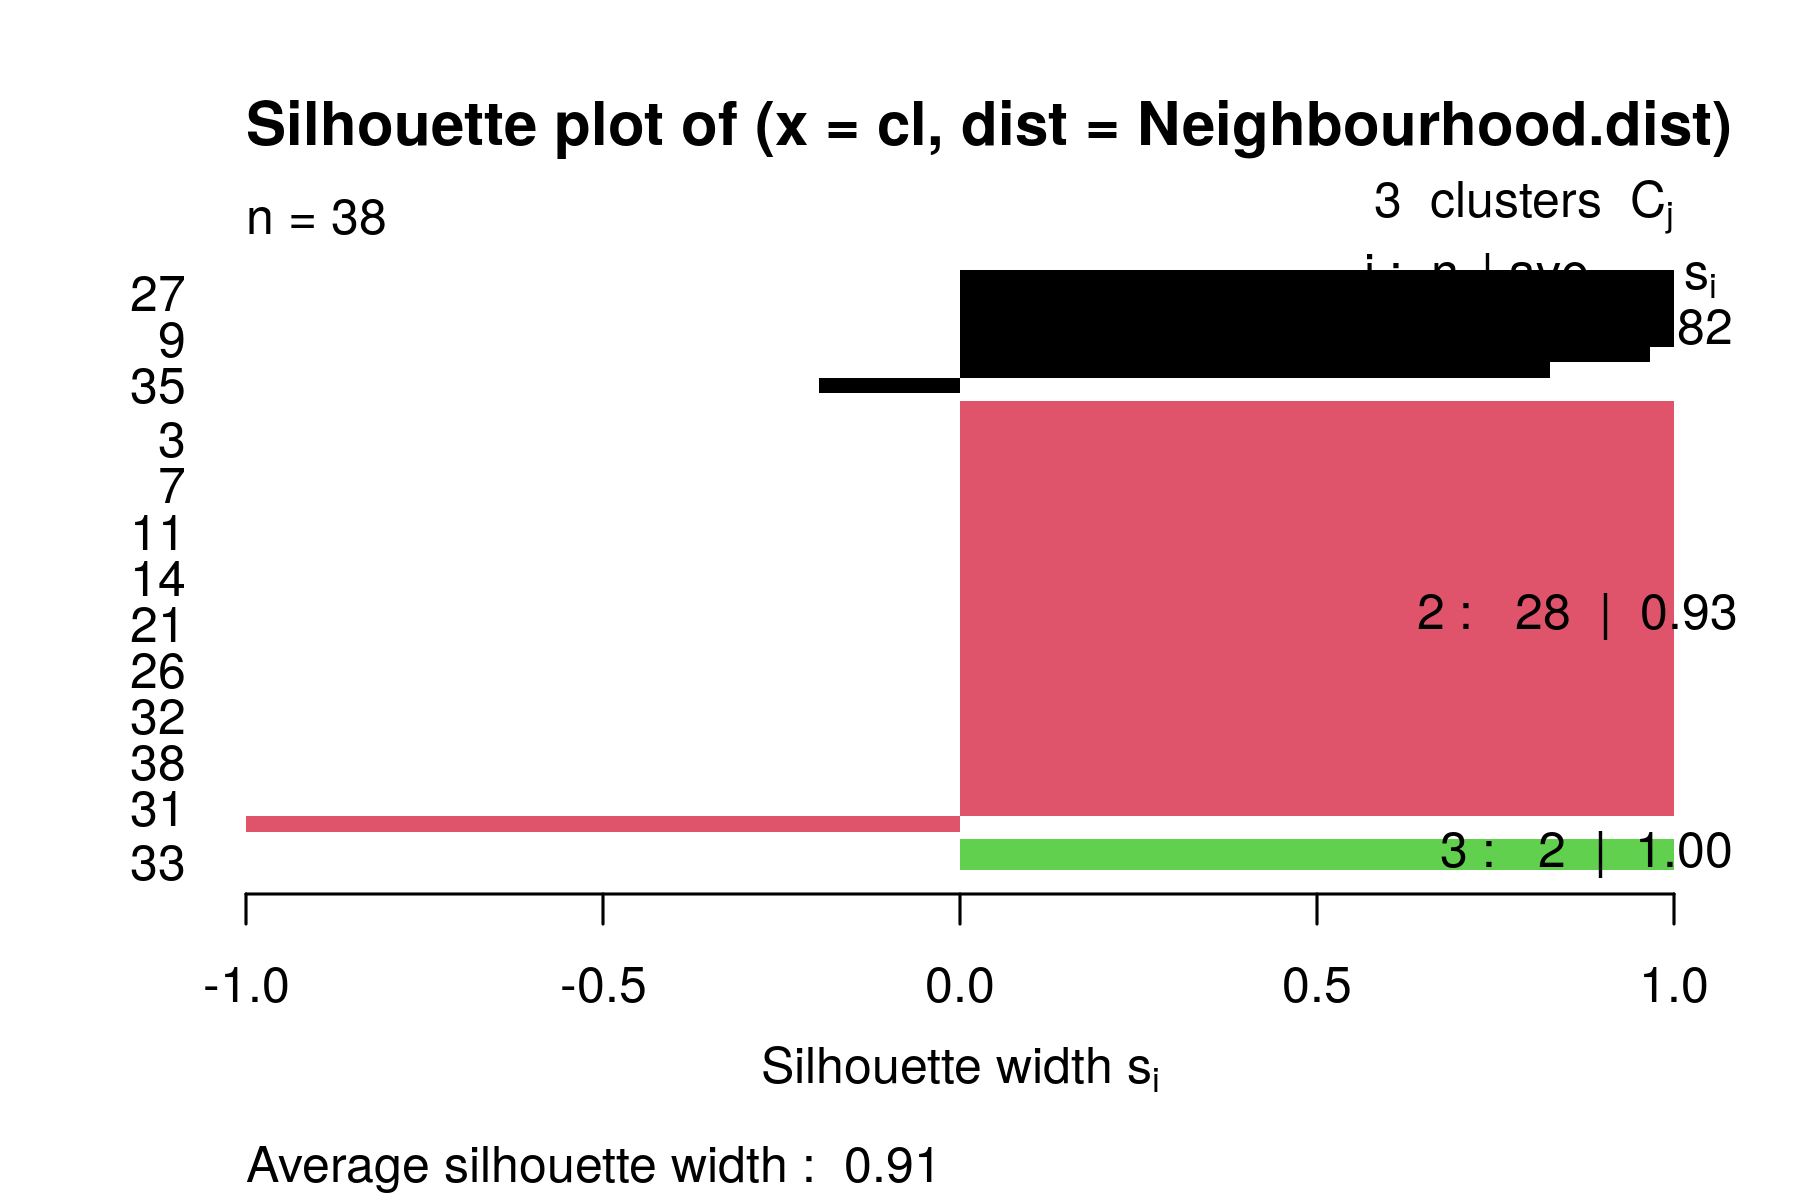

In [348]:
#En base al análisis realizado vamos a optar por generar 3 clusters
#Vamos a graficar los valores de silhouette de cada cluster para el corte elegido h=3

cl <- cutree_1h.dendrogram(hcd,h=0.4)   
ss<-silhouette(cl, Neighbourhood.dist)
plot(ss,col=1:max(cl),border=NA)


Vamos a crear una nueva columna en el dataframe df_madrid con un nuevo identificador marcado por los clusters obtenidos. Esta columna la llamaremos neighb_id

In [349]:
cl <- as.data.frame(cl ,stringsAsFactors= TRUE)
colnames(cl)<-'neighb_id'
df_madrid <- merge(df_madrid,cl,by.x='Neighbourhood',by.y=0)
df_madrid$neighb_id <- as.factor(df_madrid$neighb_id)

Vamos a crear dos grupos, uno test y otro train.

Tratamos de predecir los metros cuadrados en función del resto de columnas del dataframe.

In [350]:
library(tidyr)
set.seed(1)

df_madrid |> drop_na(Square.Meters) -> df_madrid_lm
#Tras eliminar las filas que tiene Square.Meter con NA creamos los dos grupos, 70% para training y 30% para test
idx<-sample(1:nrow(df_madrid_lm),nrow(df_madrid_lm)*0.7)
df_madrid.train=df_madrid_lm[idx,]
df_madrid.test=df_madrid_lm[-idx,]

**Generamos un primer modelo con todos las variables menos Neighbourhood y Square.Feet**

In [351]:
lm_model <- lm(Square.Meters~. -Neighbourhood -Square.Feet , data=df_madrid.train)
summary(lm_model)


Call:
lm(formula = Square.Meters ~ . - Neighbourhood - Square.Feet, 
    data = df_madrid.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-52.991 -10.201  -0.946   7.573  57.044 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -6.319e+03  5.297e+03  -1.193   0.2357    
Accommodates          3.039e+00  1.822e+00   1.668   0.0983 .  
Bathrooms             1.387e+01  5.058e+00   2.743   0.0072 ** 
Bedrooms              1.921e+01  3.032e+00   6.335 6.67e-09 ***
Beds                 -3.062e+00  2.058e+00  -1.488   0.1399    
Price                 6.283e-02  3.905e-02   1.609   0.1107    
Guests.Included      -2.157e+00  1.860e+00  -1.160   0.2489    
Extra.People          5.371e-01  2.080e-01   2.582   0.0113 *  
Review.Scores.Rating  4.130e-01  2.230e-01   1.852   0.0669 .  
Latitude              1.754e+02  1.275e+02   1.375   0.1721    
Longitude             2.142e+02  1.091e+02   1.963   0.0524 .  
neighb_id2           -1.0

**Generamos el modelo con los datos de training**

In [352]:
formula <- Square.Meters~Accommodates+Beds+Bathrooms+Bedrooms+Price+Review.Scores.Rating+neighb_id
lm_model <- lm(formula , data=df_madrid.train)
summary(lm_model)


Call:
lm(formula = formula, data = df_madrid.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-65.887 -10.371  -2.258   8.580  57.441 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -5.90303   21.09556  -0.280  0.78016    
Accommodates           3.10202    1.80211   1.721  0.08814 .  
Beds                  -3.01045    2.13823  -1.408  0.16211    
Bathrooms             16.14250    4.84258   3.333  0.00119 ** 
Bedrooms              18.15502    3.02081   6.010 2.72e-08 ***
Price                  0.05436    0.03923   1.386  0.16876    
Review.Scores.Rating   0.23837    0.22617   1.054  0.29433    
neighb_id2           -10.07827    4.00956  -2.514  0.01347 *  
neighb_id3             4.34951   15.53261   0.280  0.78001    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 17.77 on 105 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.7286,	Adjusted

**Generamos una nueva columna en el df con los valores de Square.Meters predicho por nuestro modelo**

[1] "Valores del modelo en training:"

RMSE   Rsquared        MAE 
17.0522272  0.7286221 12.5897687

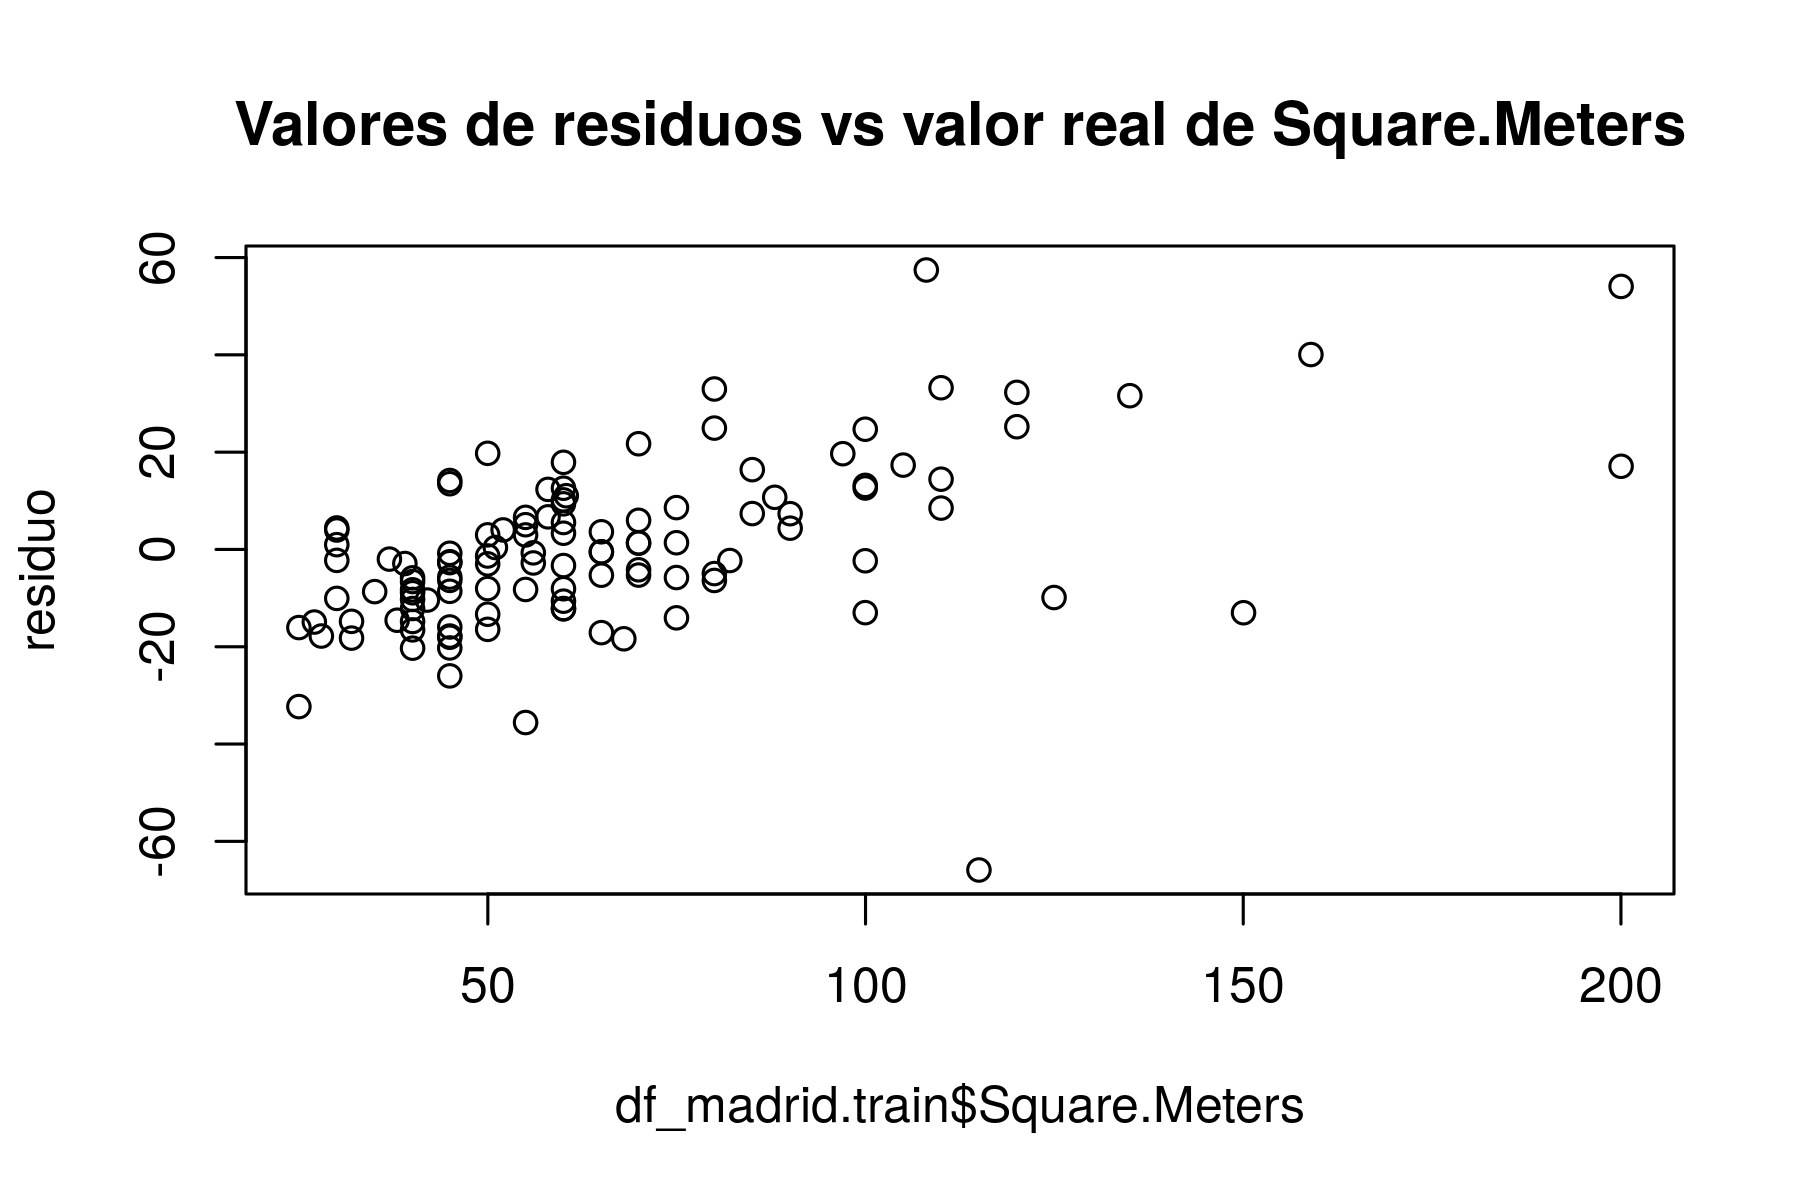

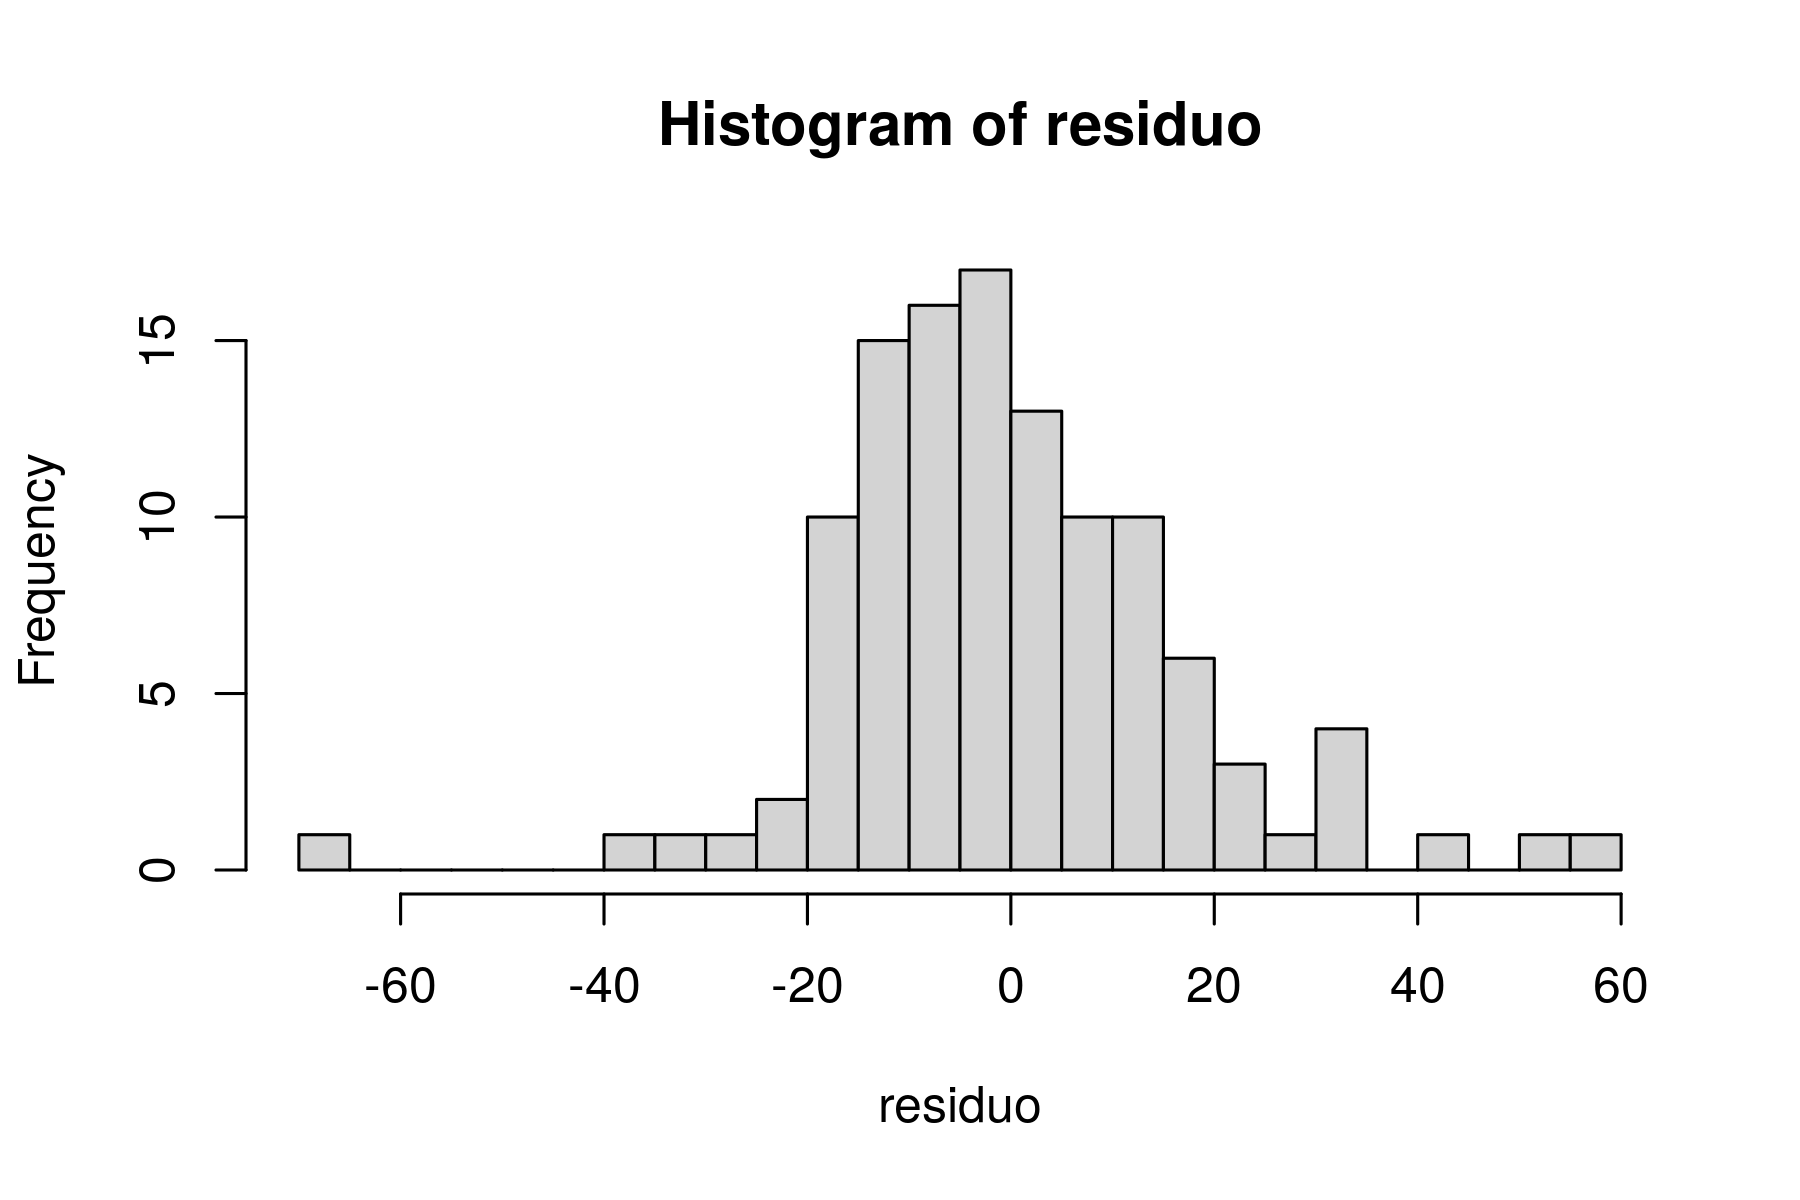

In [353]:
df_madrid.train$SqMePredict <- predict(lm_model, df_madrid.train)
paste('Valores del modelo en training:')
caret::postResample(pred=df_madrid.train$SqMePredict, obs= df_madrid.train$Square.Meters)
residuo <- df_madrid.train$Square.Meters-df_madrid.train$SqMePredict
plot(df_madrid.train$Square.Meters,residuo, main='Valores de residuos vs valor real de Square.Meters')
hist(residuo,20)


**Generamos grafica qqnorm para ver si sigue una distribución normal**

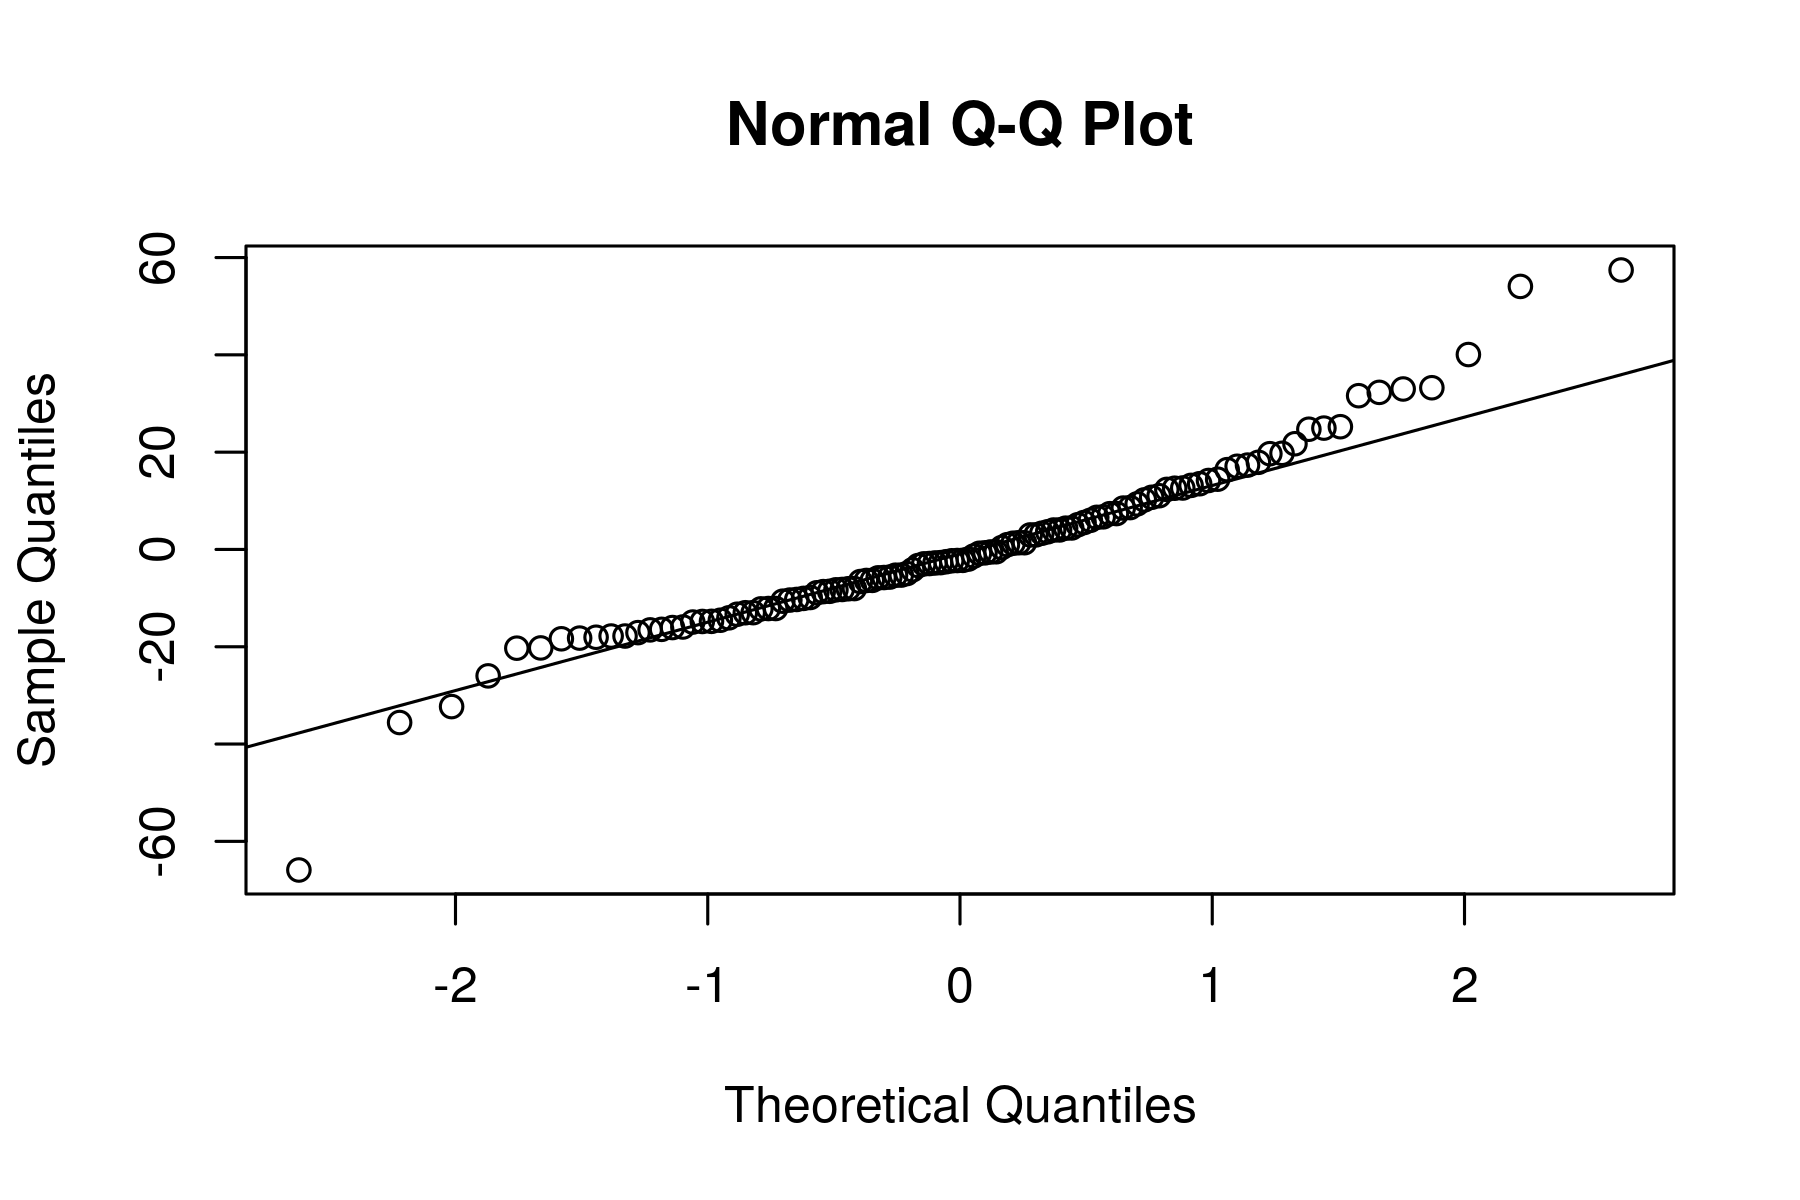

In [354]:
qqnorm(residuo)
qqline(residuo)

**Dado que en la gráfica anterior hemos obtenido puntos bastante alejados de la recta, calculamos la distancia de cook para valorar la eliminación de posibles outliers**

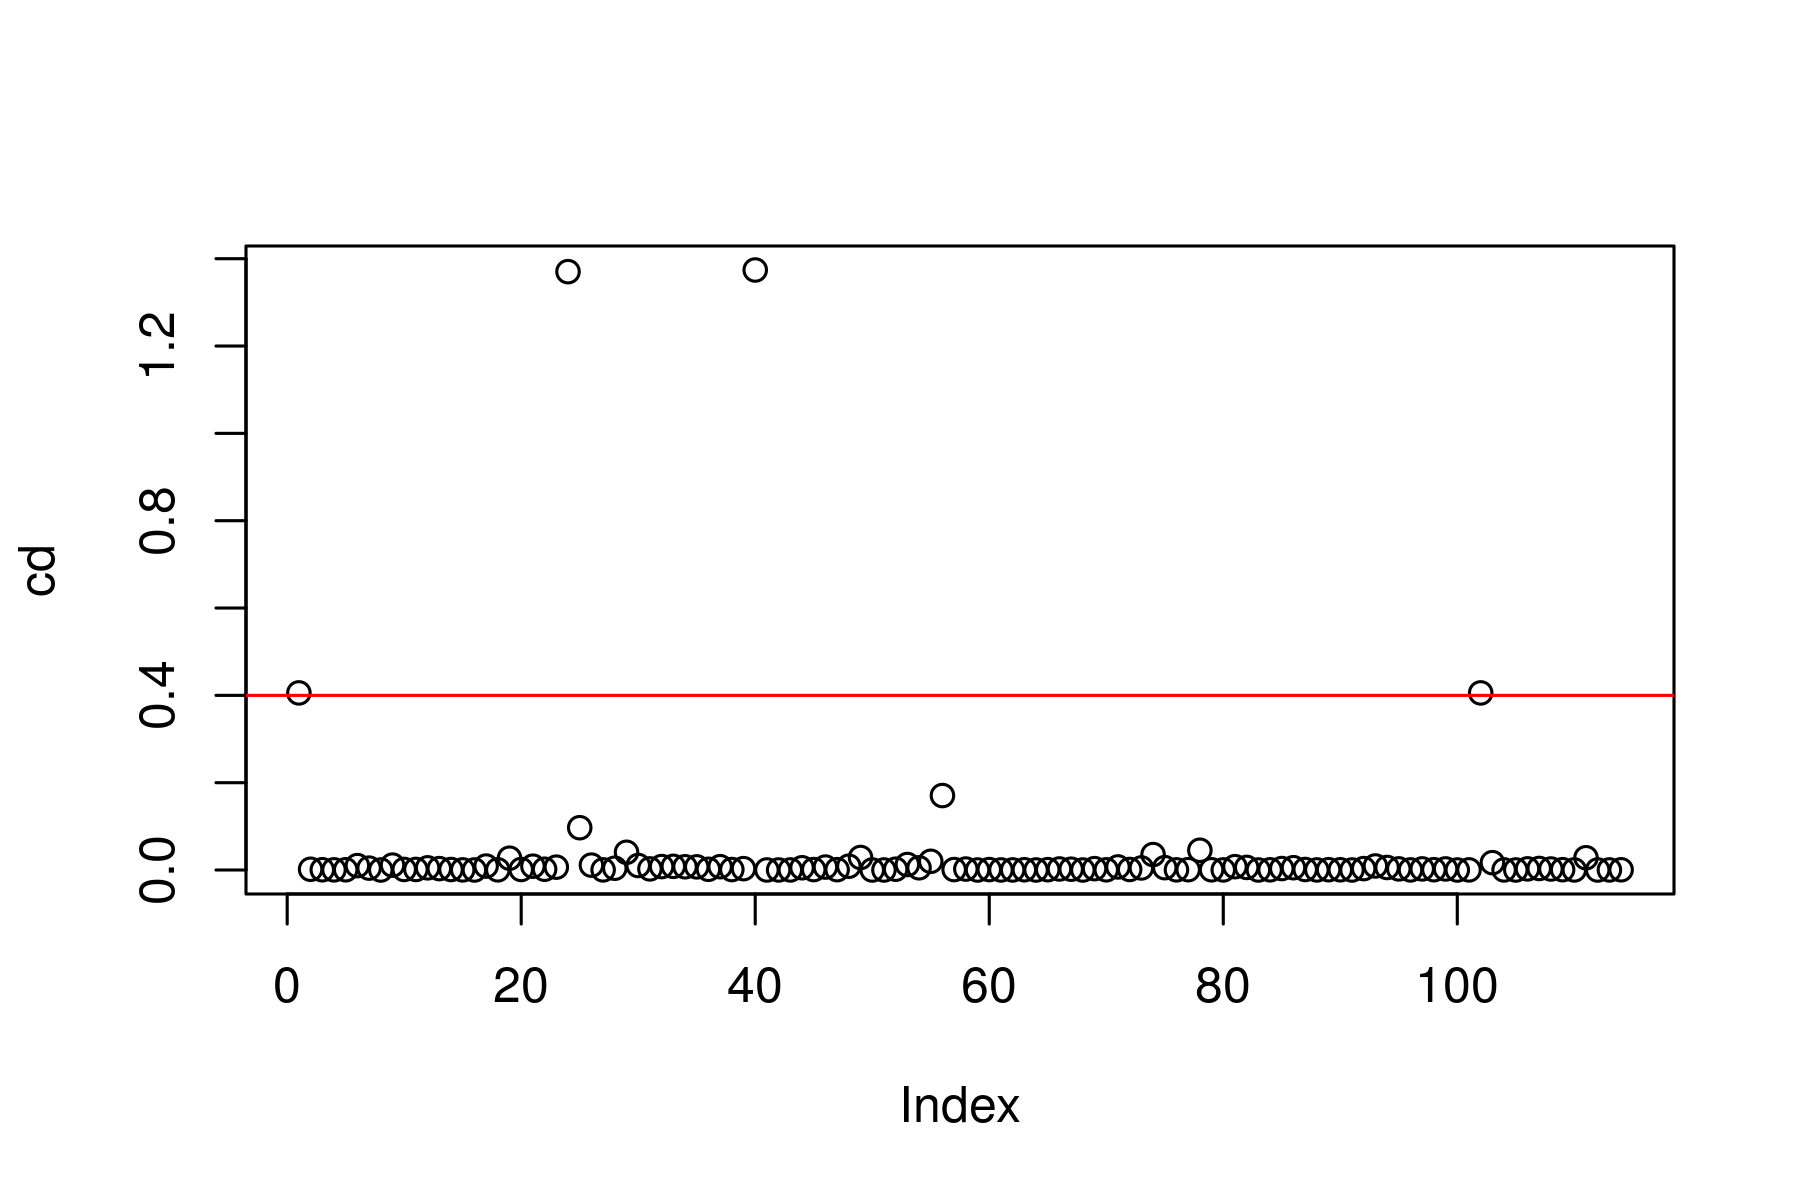

In [355]:
cd <- cooks.distance(lm_model)
plot(cd)
abline(h=0.4,col='red')

**Realizamos una pequeña limpieza de los datos eliminado outlies**

In [356]:
df_madrid.train_clean <- df_madrid.train[cd<0.4,]

In [357]:
#A pesar de obtener un pvalor alto en coeficientes como Beds y Review.Scores.Rating
#optamos por no eliminarlos ya que no mejoraba el modelo
formula <- Square.Meters~Accommodates+Beds+Bathrooms+Bedrooms+Price+Review.Scores.Rating+neighb_id
lm_model_final <- lm(formula, data=df_madrid.train_clean)
summary(lm_model_final)


Call:
lm(formula = formula, data = df_madrid.train_clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-63.797 -10.024  -1.829   7.928  52.162 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -3.0964    20.8642  -0.148   0.8823    
Accommodates           3.3214     1.7899   1.856   0.0664 .  
Beds                  -1.8729     2.2083  -0.848   0.3984    
Bathrooms             10.0355     5.2649   1.906   0.0595 .  
Bedrooms              14.2137     3.3607   4.229 5.16e-05 ***
Price                  0.1742     0.0726   2.400   0.0182 *  
Review.Scores.Rating   0.1717     0.2282   0.752   0.4536    
neighb_id2            -6.2966     4.4120  -1.427   0.1566    
neighb_id3            38.6344    23.6623   1.633   0.1056    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 17.46 on 101 degrees of freedom
  (6 observations deleted due to missingness)
Multiple R-squared:  0.7478,	Adjusted R-s

**Volvemos a realizar la predicción en base al nuevo df sin outliers**

[1] "Valores del modelo en training con outliers:"

RMSE   Rsquared        MAE 
17.0522272  0.7286221 12.5897687

[1] "Valores del modelo en training eliminando outliers:"

RMSE   Rsquared        MAE 
16.7309581  0.7477569 12.2554034

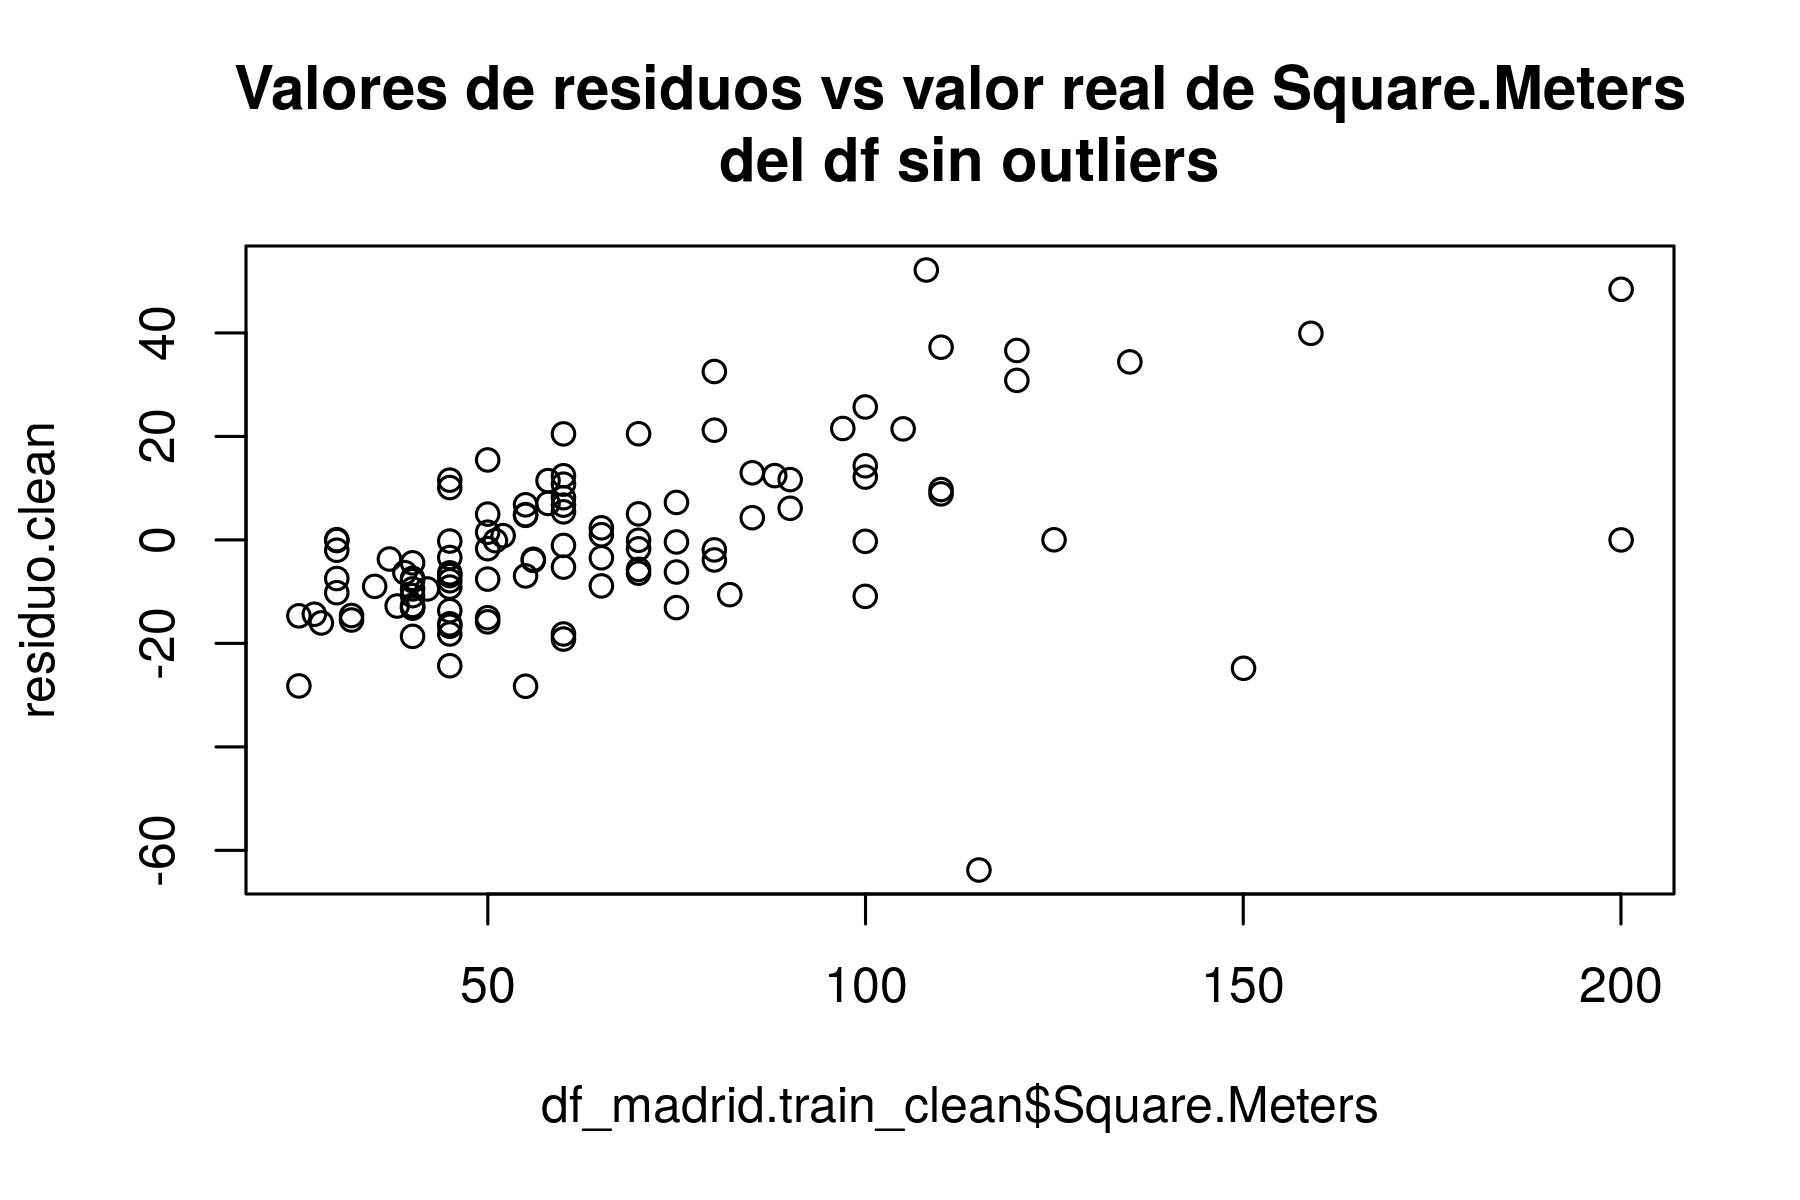

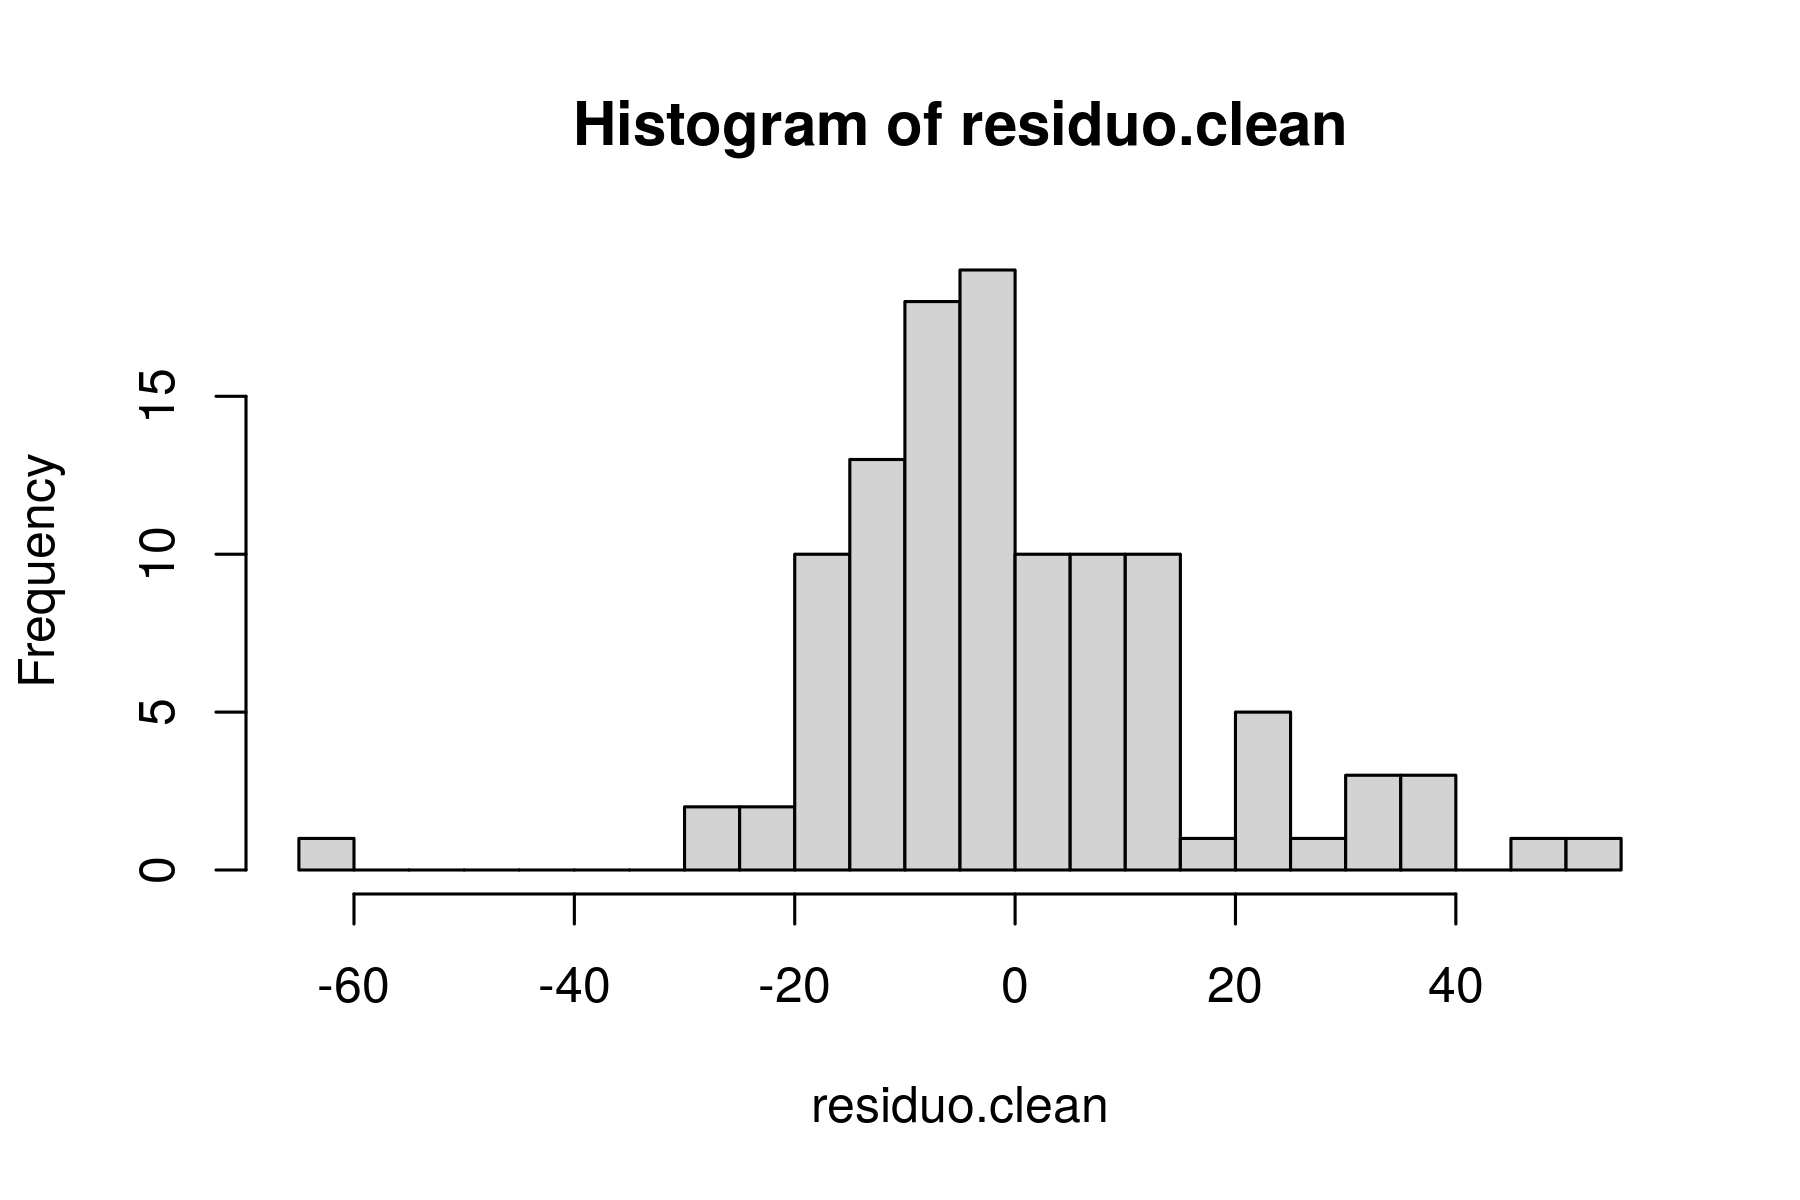

In [358]:
paste('Valores del modelo en training con outliers:')
caret::postResample(pred=df_madrid.train$SqMePredict, obs= df_madrid.train$Square.Meters)

#Generamos nuevo modelo 
df_madrid.train_clean$SqMePredict <- predict(lm_model_final, df_madrid.train_clean)
paste('Valores del modelo en training eliminando outliers:')
caret::postResample(pred=df_madrid.train_clean$SqMePredict, obs= df_madrid.train_clean$Square.Meters)
residuo.clean <- df_madrid.train_clean$Square.Meters-df_madrid.train_clean$SqMePredict
plot(df_madrid.train_clean$Square.Meters,residuo.clean, main='Valores de residuos vs valor real de Square.Meters\n del df sin outliers')
hist(residuo.clean,20)

[1] "A pesar de haber mejorado el r2 y el RMSE no se aprecia una gran mejora en la gráfica la eliminación de outliers"

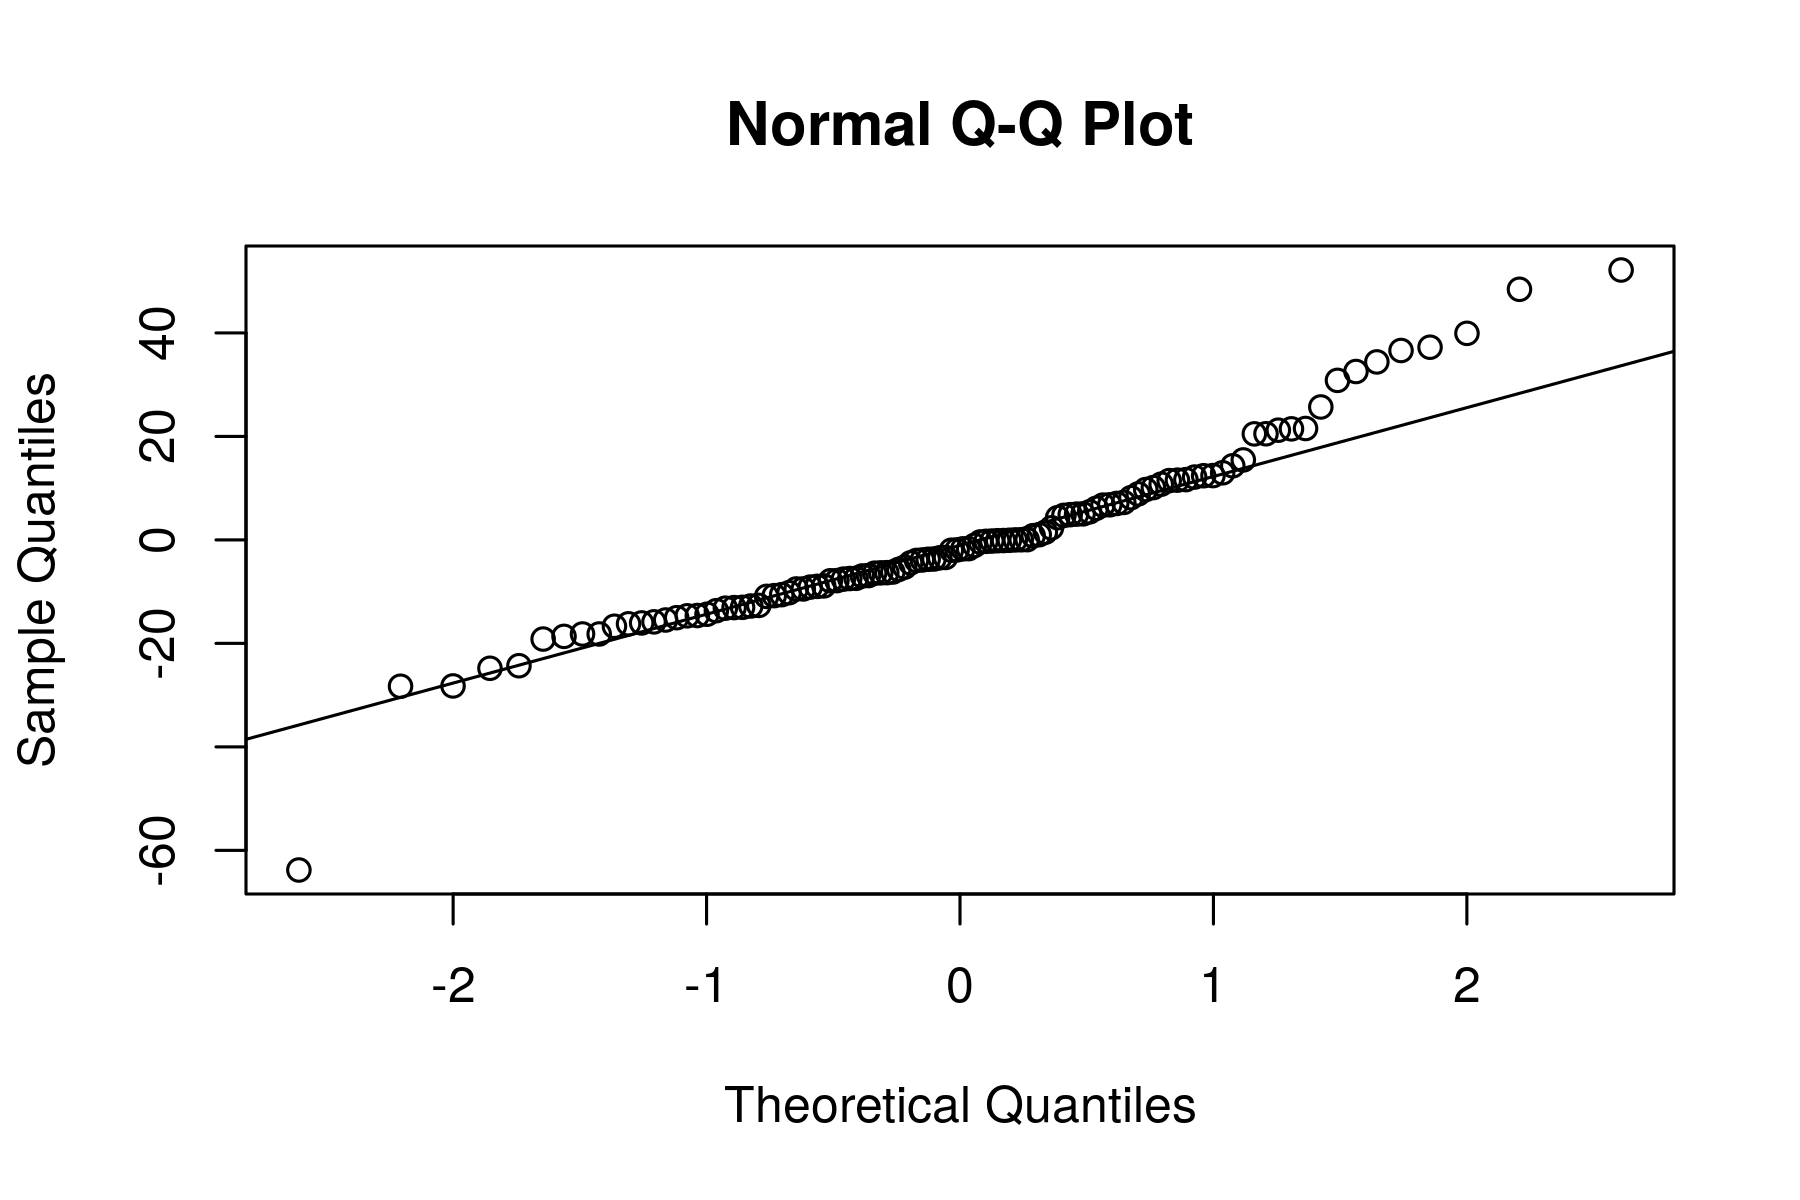

In [359]:
#Generamos grafica qqnorm para ver si ha mejorado la distribución tras eliminar los outliers
qqnorm(residuo.clean)
qqline(residuo.clean)
paste('A pesar de haber mejorado el r2 y el RMSE no se aprecia una gran mejora en la gráfica la eliminación de outliers')

**Vamos a probar a estandarizar los datos a ver si mejora el modelo**

In [360]:
preProcValues <- caret::preProcess(df_madrid.train, method = c("center", "scale"))
df_madrid_norm.train <- predict(preProcValues,df_madrid.train)


In [361]:
#formula = Square.Meters~Accommodates+Beds+Bathrooms+Bedrooms+Price+Review.Scores.Rating+neighb_id
paste('Modelo sin estandarizar:')
lm_model_final <- lm(formula , data=df_madrid.train_clean)
summary(lm_model_final)
paste('Modelo estandarizado:')
lm_model_est_final <- lm(formula , data=df_madrid_norm.train)
summary(lm_model_est_final)

[1] "Modelo sin estandarizar:"


Call:
lm(formula = formula, data = df_madrid.train_clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-63.797 -10.024  -1.829   7.928  52.162 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -3.0964    20.8642  -0.148   0.8823    
Accommodates           3.3214     1.7899   1.856   0.0664 .  
Beds                  -1.8729     2.2083  -0.848   0.3984    
Bathrooms             10.0355     5.2649   1.906   0.0595 .  
Bedrooms              14.2137     3.3607   4.229 5.16e-05 ***
Price                  0.1742     0.0726   2.400   0.0182 *  
Review.Scores.Rating   0.1717     0.2282   0.752   0.4536    
neighb_id2            -6.2966     4.4120  -1.427   0.1566    
neighb_id3            38.6344    23.6623   1.633   0.1056    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 17.46 on 101 degrees of freedom
  (6 observations deleted due to missingness)
Multiple R-squared:  0.7478,	Adjusted R-s

[1] "Modelo estandarizado:"


Call:
lm(formula = formula, data = df_madrid_norm.train)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.91406 -0.30129 -0.06559  0.24925  1.66870 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           0.21386    0.09684   2.208  0.02939 *  
Accommodates          0.17720    0.10295   1.721  0.08814 .  
Beds                 -0.13677    0.09715  -1.408  0.16211    
Bathrooms             0.26763    0.08029   3.333  0.00119 ** 
Bedrooms              0.52401    0.08719   6.010 2.72e-08 ***
Price                 0.10787    0.07784   1.386  0.16876    
Review.Scores.Rating  0.05225    0.04957   1.054  0.29433    
neighb_id2           -0.29278    0.11648  -2.514  0.01347 *  
neighb_id3            0.12636    0.45123   0.280  0.78001    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5162 on 105 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.7286,	Ad

**Como en principio el modelo no mejora estandarizándolo lo dejamos sin estandarizar
y realizamos la predicción sobre los datos de test**

[1] "Resultado obtenido con los datos de test en el modelo"

RMSE   Rsquared        MAE 
38.6925262  0.7083926 21.0198163

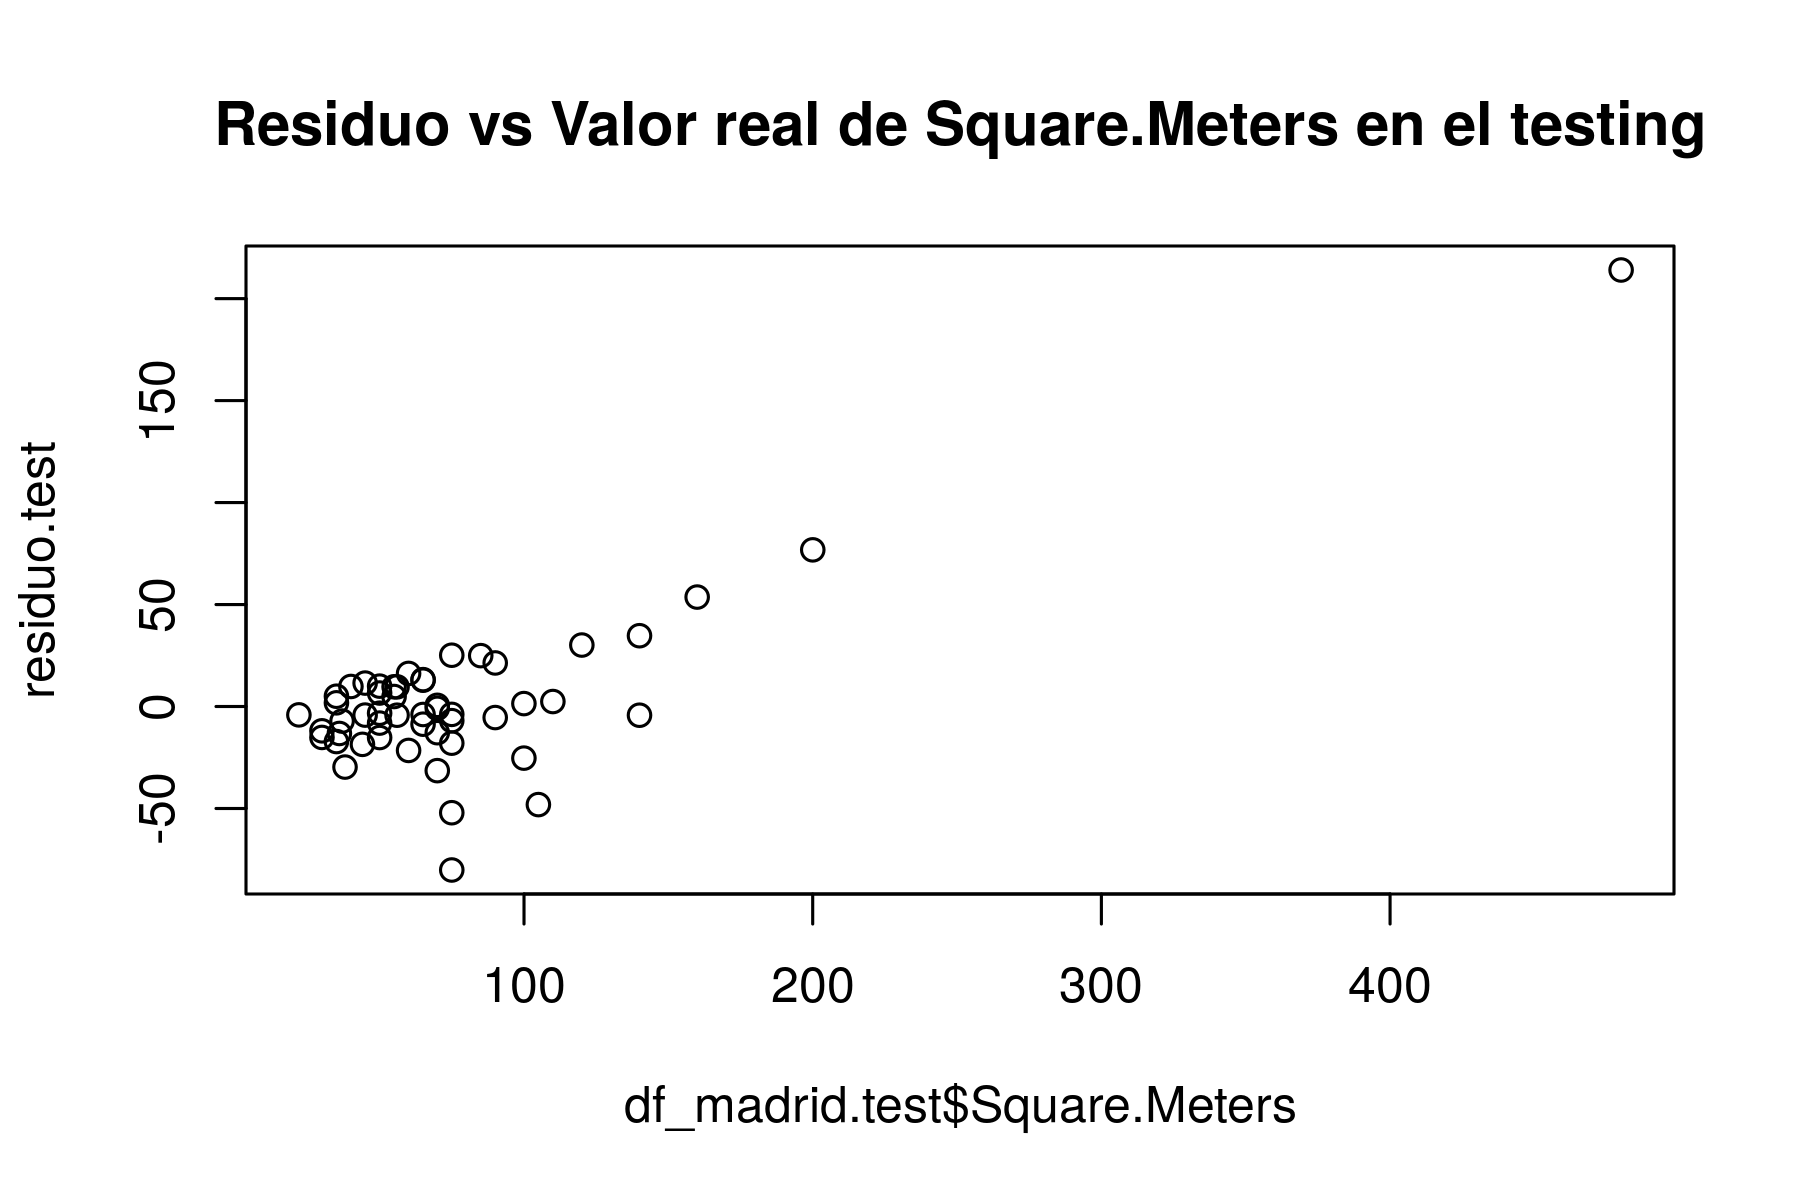

In [362]:
df_madrid.test$SqMePredict <- predict(lm_model_final,df_madrid.test)
residuo.test <- df_madrid.test$Square.Meters - df_madrid.test$SqMePredict
plot(df_madrid.test$Square.Meters, residuo.test, main='Residuo vs Valor real de Square.Meters en el testing')
paste('Resultado obtenido con los datos de test en el modelo')
caret::postResample(pred=df_madrid.test$SqMePredict, obs= df_madrid.test$Square.Meters)



In [363]:
paste('Resultado del training') 
caret::postResample(pred=df_madrid.train_clean$SqMePredict, obs= df_madrid.train_clean$Square.Meters)
paste('Resultado del testing') 
caret::postResample(pred=df_madrid.test$SqMePredict, obs= df_madrid.test$Square.Meters)

[1] "Resultado del training"

RMSE   Rsquared        MAE 
16.7309581  0.7477569 12.2554034

[1] "Resultado del testing"

RMSE   Rsquared        MAE 
38.6925262  0.7083926 21.0198163

**Regularización:**

Debido a que en el modelo lineal obtenido en el apartado anterior, en el resultado de testing hemos obtenido un R2 mas pequeño que en el de training, vamos a realizar una regularización para ver si podemos eliminar ese posible overfitting. 
Vamos a realizar una regularización de Lasso: 


Primeramnete vamos a calcular el valor de lambda optimo:

In [376]:
library(glmnet)     
df_madrid.train_clean2 <- na.omit(df_madrid.train_clean) #eliminamos las filas que tengan algún NA para realizar el modelo
cv <-  glmnetUtils::cv.glmnet(formula= formula,
                                data = df_madrid.train_clean2,
                                alpha=1, #Lasso
                                nfold=10,
                                type.measure="mse",
                                standardize = T)
paste0("El valor lambda con el menor error es:",cv$lambda.min)
paste0("El valor lambda más alto que se encuentra a una distancia 1sd es:",cv$lambda.1se)
paste0("El R^2 estimado es", 
       cv$glmnet.fit$dev.ratio[which(cv$glmnet.fit$lambda == cv$lambda.1se)]) 

[1] "El valor lambda con el menor error es:0.0510902525664386"

[1] "El valor lambda más alto que se encuentra a una distancia 1sd es:8.52236777517629"

[1] "El R^2 estimado es0.640753606488349"

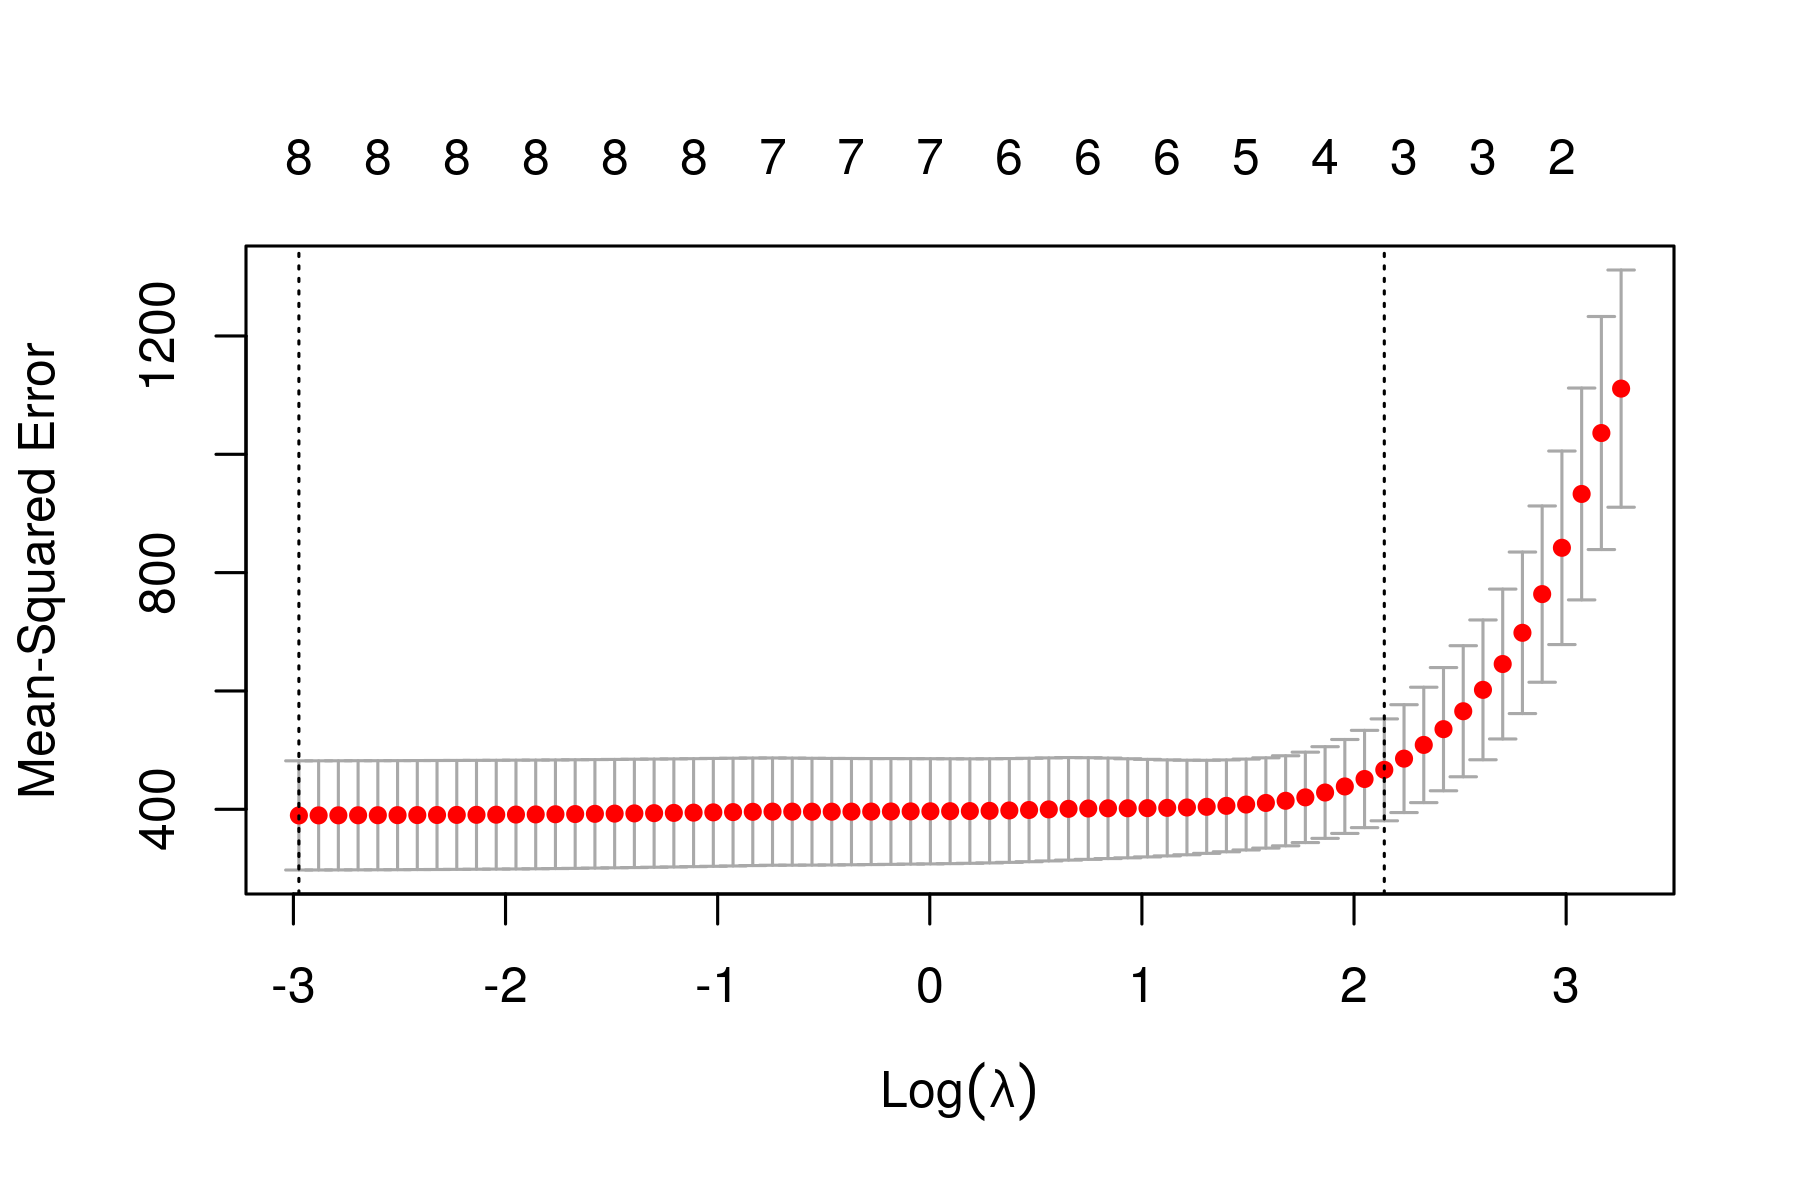

In [377]:
plot(cv)

**Realizamos la predicción con el modelo sobre los datos de training optando por el lambda.min, ya que tomando el lambda.1se si que es verdad que nos simplificaria mucho el modelo, pero obtenemos mejores resultados con el lambda minimo**

In [378]:
reg_yp_train<- predict(cv,
                     df_madrid.train_clean2, 
                     s=cv$lambda.min)
paste('Los coeficientes obtenidos tras la regularización:')
coef(cv, s = "lambda.min")

paste('Modelo obtenido sin regularización')
summary(lm_model_final)

paste('Resultado modelo regularizado probado con datos de training')
caret::postResample(reg_yp_train,df_madrid.train_clean2$Square.Meters)
paste('Resultado modelo sin regularizar probado con datos de training') 
caret::postResample(pred=df_madrid.train_clean$SqMePredict, obs= df_madrid.train_clean$Square.Meters)


[1] "Los coeficientes obtenidos tras la regularización:"

10 x 1 sparse Matrix of class "dgCMatrix"
                             s1
(Intercept)          -2.2591875
Accommodates          3.1808406
Beds                 -1.6272403
Bathrooms            10.0662215
Bedrooms             14.0726844
Price                 0.1740714
Review.Scores.Rating  0.1636302
neighb_id1            .        
neighb_id2           -6.1854453
neighb_id3           39.0410035

[1] "Modelo obtenido sin regularización"


Call:
lm(formula = formula, data = df_madrid.train_clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-63.797 -10.024  -1.829   7.928  52.162 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -3.0964    20.8642  -0.148   0.8823    
Accommodates           3.3214     1.7899   1.856   0.0664 .  
Beds                  -1.8729     2.2083  -0.848   0.3984    
Bathrooms             10.0355     5.2649   1.906   0.0595 .  
Bedrooms              14.2137     3.3607   4.229 5.16e-05 ***
Price                  0.1742     0.0726   2.400   0.0182 *  
Review.Scores.Rating   0.1717     0.2282   0.752   0.4536    
neighb_id2            -6.2966     4.4120  -1.427   0.1566    
neighb_id3            38.6344    23.6623   1.633   0.1056    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 17.46 on 101 degrees of freedom
  (6 observations deleted due to missingness)
Multiple R-squared:  0.7478,	Adjusted R-s

[1] "Resultado modelo regularizado probado con datos de training"

RMSE   Rsquared        MAE 
16.7322801  0.7477222 12.2671170

[1] "Resultado modelo sin regularizar probado con datos de training"

RMSE   Rsquared        MAE 
16.7309581  0.7477569 12.2554034

**Realizamos la prueba en los datos de testing**

In [379]:
df_madrid.test2 <- na.omit(df_madrid.test) 
reg_yp_test<- predict(cv,
                     df_madrid.test2, 
                     s=cv$lambda.min)

paste('Resultado modelo regularizado probado con datos de testing')
caret::postResample(reg_yp_test,df_madrid.test2$Square.Meters)
paste('Resultado modelo sin regularizar probado con datos de testing') 
caret::postResample(pred=df_madrid.test$SqMePredict, obs= df_madrid.test$Square.Meters)

[1] "Resultado modelo regularizado probado con datos de testing"

RMSE   Rsquared        MAE 
38.6067095  0.7100547 20.9659491

[1] "Resultado modelo sin regularizar probado con datos de testing"

RMSE   Rsquared        MAE 
38.6925262  0.7083926 21.0198163

**En base a los datos obtenidos en la prueba anterior podemos observar que el modelo regularizado se comporta un poco mejor en los datos de testing que la simple regresión lineal, aunque no es una diferencia muy representativa**

Mirad el histograma de los residuos sobre el conjunto de test para evaluar la calidad de vuestro modelo

**Realizamos histograma con modelo regularizado**

[1] "Los histogramas parece que siguen una distribución normal, pero tenemos que tener en cuenta que se está realizando en base a una muestra muy pequeña"

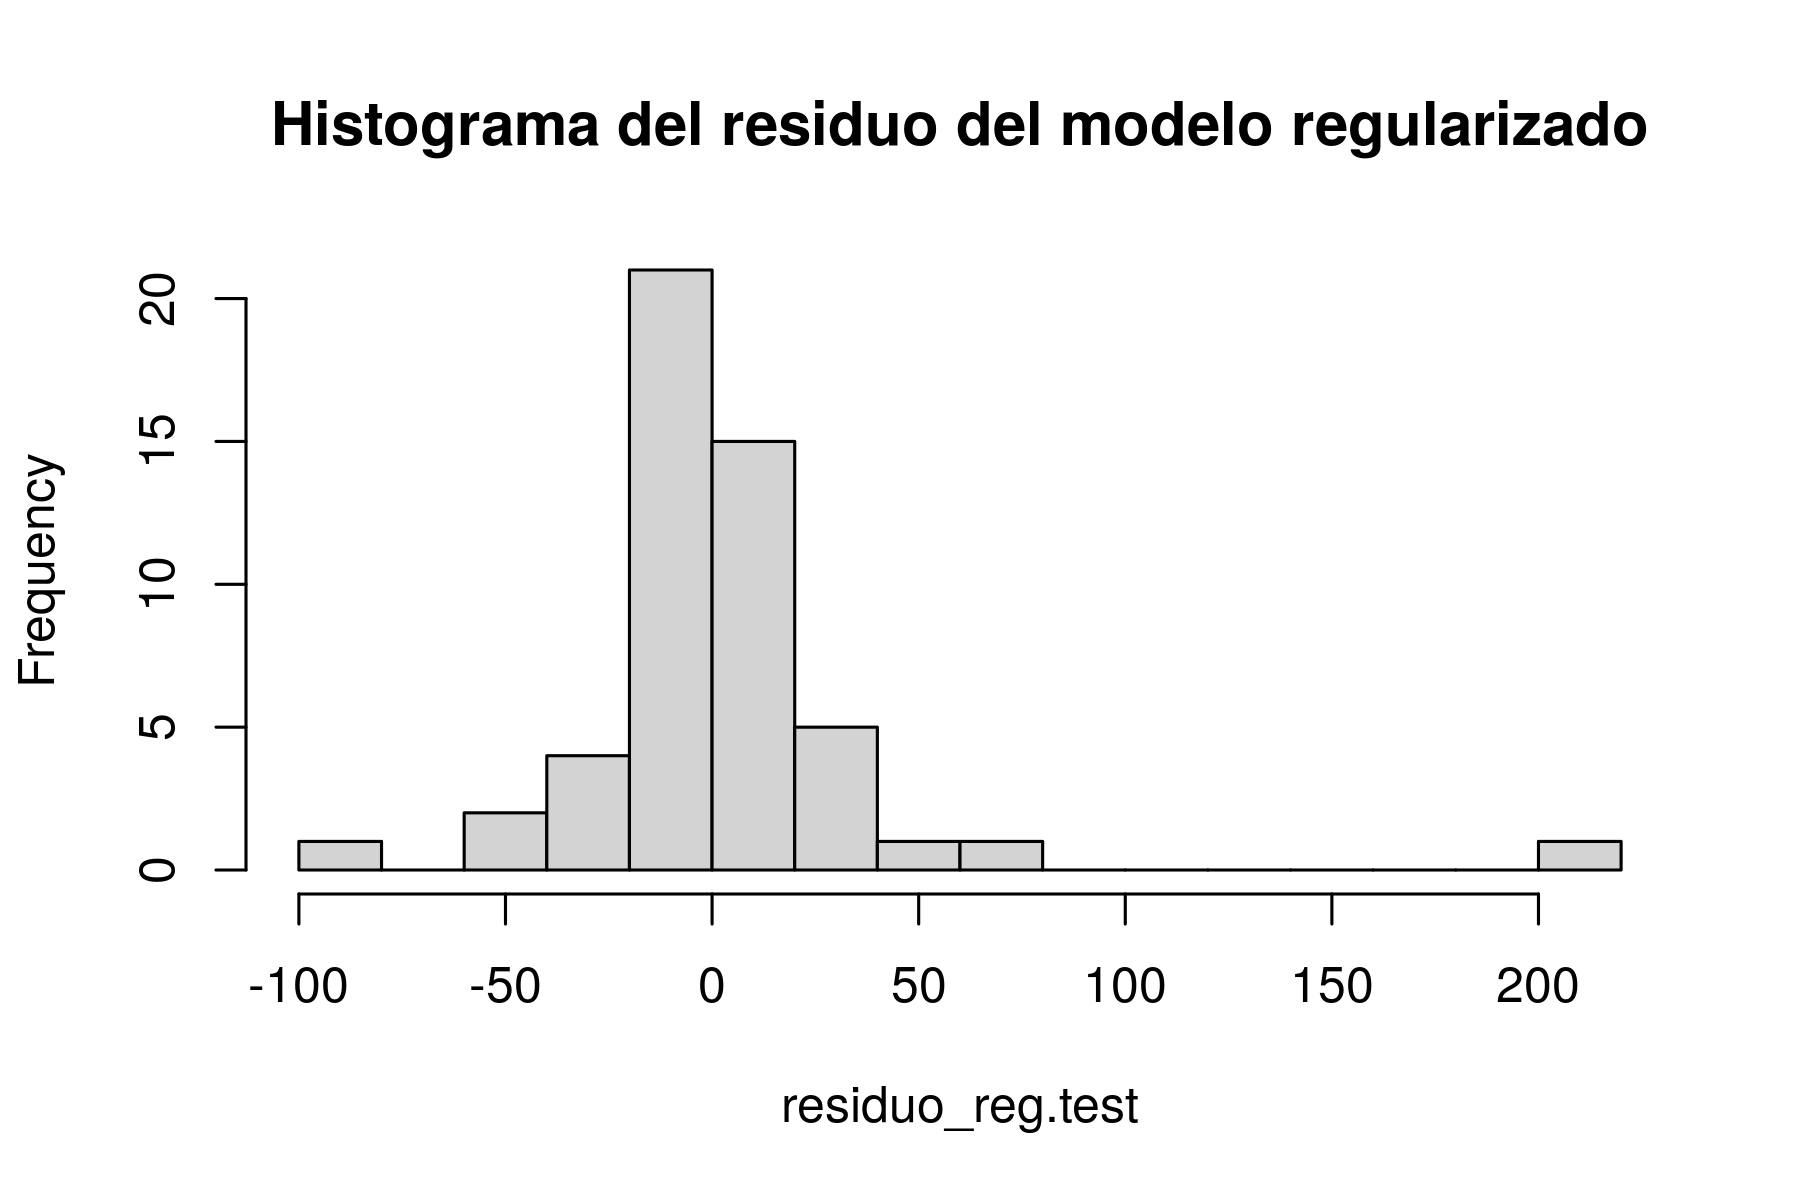

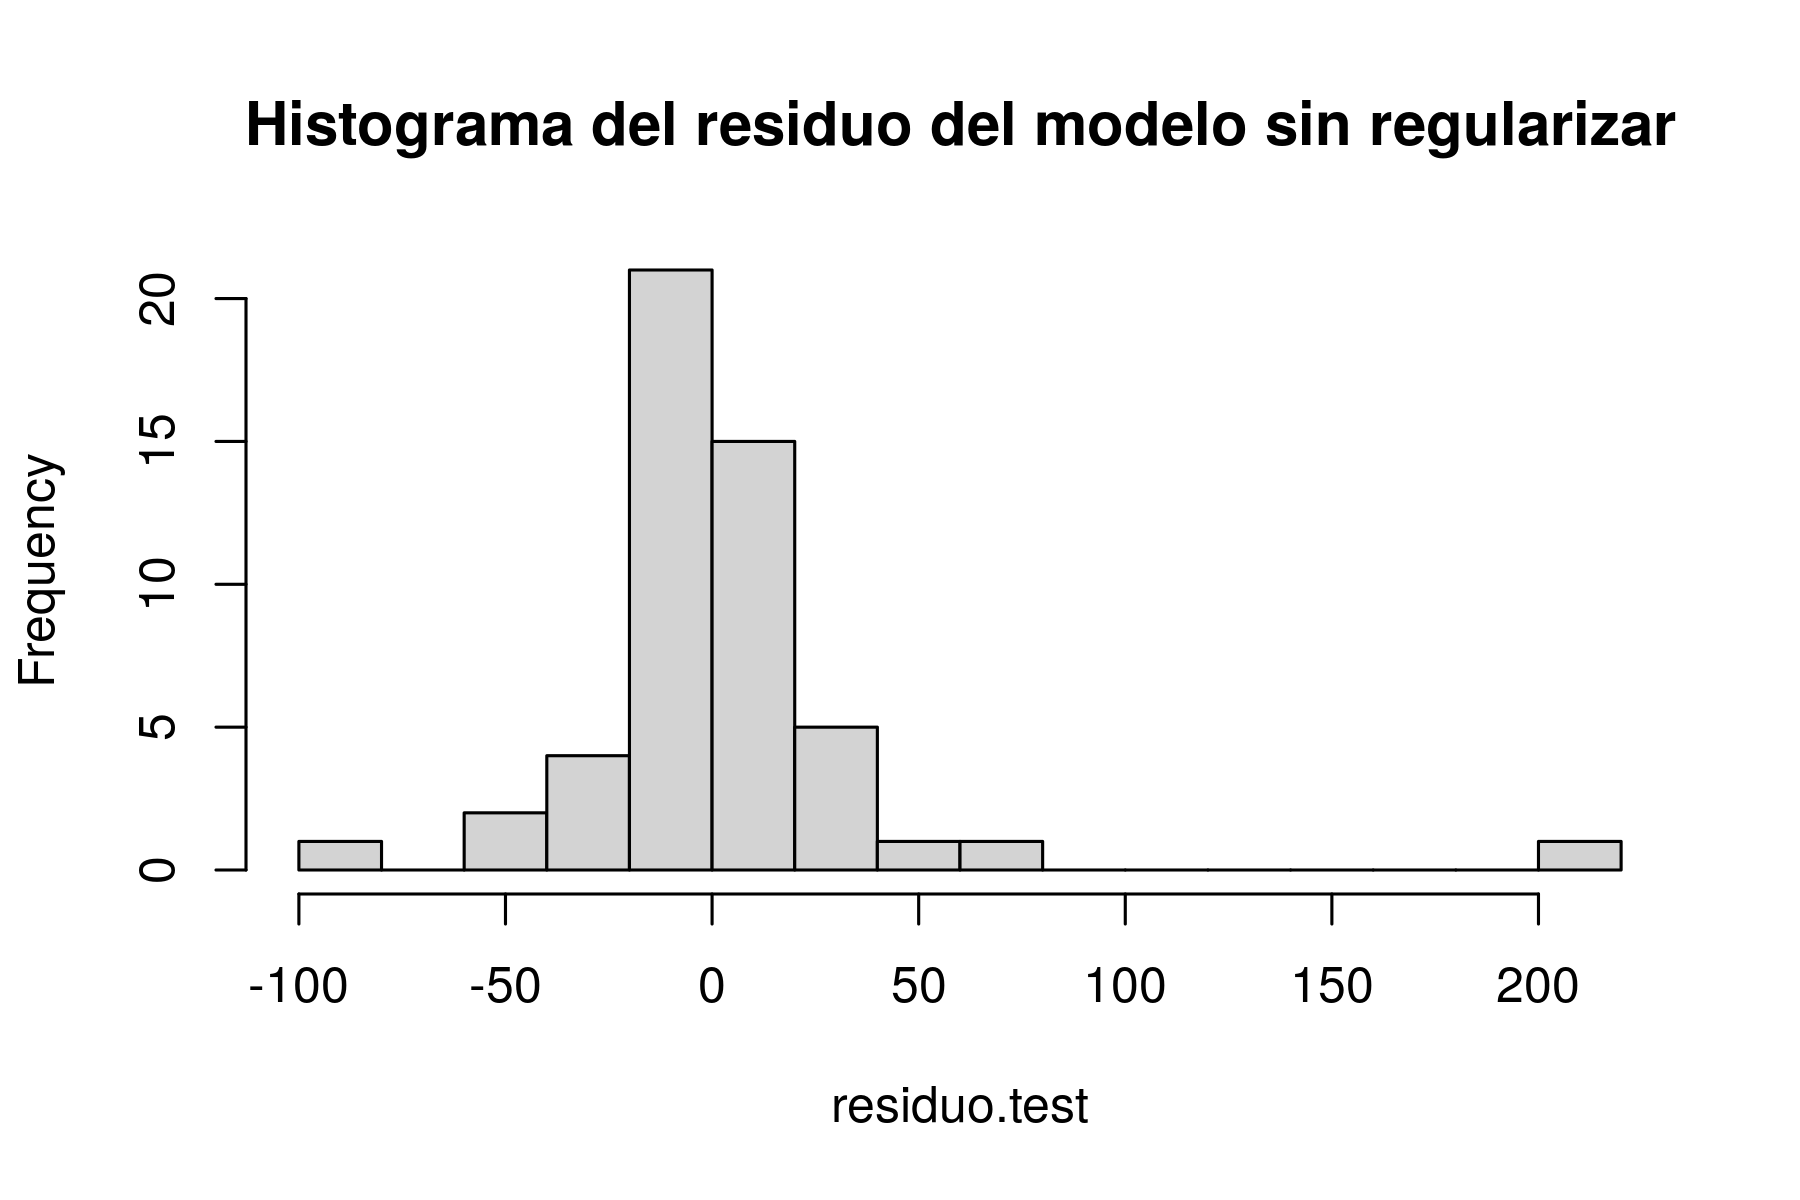

In [380]:
paste('Los histogramas parece que siguen una distribución normal, pero tenemos que tener en cuenta que se está realizando en base a una muestra muy pequeña')
residuo_reg.test <- df_madrid.test2$Square.Meters - reg_yp_test #calculamos el residuo del modelo regularizado con Lasso
hist(residuo_reg.test,20, main='Histograma del residuo del modelo regularizado')
hist(residuo.test,20, main='Histograma del residuo del modelo sin regularizar')



Si tuvieramos un anuncio de un apartamento para 6 personas (Accommodates), con 1 baño, con un precio de 80€/noche y 3 habitaciones en el barrio de Sol, con 3 camas y un review de 80.
¿Cuantos metros cuadrados tendría? Si tu modelo necesita algúna variable adicional puedes inventartela dentro del rango de valores del dataset.
¿Como varía sus metros cuadrados con cada habitación adicional?

**Realizado con el modelo sin regularizar**

In [381]:
#Comprobamos a que cluster pertenece el barrio de Sol
cluster <- unique(df_madrid$neighb_id[df_madrid$Neighbourhood == 'Sol'])
consulta <- data.frame(Accommodates=6,Bathrooms=1, Price = 80,Bedrooms=3, Beds=3, Review.Scores.Rating =80, neighb_id=cluster )
metros <- predict(lm_model_final, consulta)
paste('En base a los datos aportados y según el modelo generado el apartamento tendría ', round(metros,2) , 'm2.')
paste('Por cada habitación adicional el piso aumenta en',round(lm_model_final$coef['Bedrooms'],2), 'm2')

[1] "En base a los datos aportados y según el modelo generado el apartamento tendría  91.56 m2."

[1] "Por cada habitación adicional el piso aumenta en 14.21 m2"

**Realizado con el modelo regularizado**

In [383]:
#Comprobamos a que cluster pertenece el barrio de Sol
cluster <- unique(df_madrid$neighb_id[df_madrid$Neighbourhood == 'Sol'])
consulta <- data.frame(Accommodates=6,Bathrooms=1, Price = 80,Bedrooms=3, Beds=3, Review.Scores.Rating =80, neighb_id=cluster )
metros <- predict(cv,consulta, s=cv$lambda.min)
paste('En base a los datos aportados y según el modelo generado el apartamento tendría ', round(metros,2) , 'm2.')
paste('Por cada habitación adicional el piso aumenta en',round(coef(cv, s = "lambda.min")[5],2), 'm2')




[1] "En base a los datos aportados y según el modelo generado el apartamento tendría  91.24 m2."

[1] "Por cada habitación adicional el piso aumenta en 14.07 m2"

**Podemos observar que hay una diferencia pequeña entre el modelo de regresión regularizado y sin regularizar, por lo que en principio parece que no existe overfitting en el modelo sin regularizar**

Rellenar los Square.Meters con valor NA con el estimado con el modelo anterior.

In [385]:
paste('El número de filas con Square.Meters con valores NA en df_madrid es ', sum(is.na(df_madrid$Square.Meters)))
#Realizamos la predicción con el modelo generado 
df_madrid[which(is.na(df_madrid$Square.Meters)),] <- predict(lm_model_final,df_madrid[which(is.na(df_madrid$Square.Meters)),])
paste('El número de filas con Square.Meters con valores NA en df_madrid tras realizar la predicción con el modelo es ', sum(is.na(df_madrid$Square.Meters)))


[1] "El número de filas con Square.Meters con valores NA en df_madrid es  4727"

Warning message in `[<-.factor`(`*tmp*`, iseq, value = c(62.6827801942583, NA, 131.901744669939, :
“invalid factor level, NA generated”


[1] "El número de filas con Square.Meters con valores NA en df_madrid tras realizar la predicción con el modelo es  705"

Usar PCA para encontrar el apartamento más cercano a uno dado.

Este algoritmo nos ayudaría a dado un apartamento que el algoritmo nos devolvería los 5 apartamentos más similares.


Crearemos una función tal que le pasemos un apartamento con los siguientes datos:
* Accommodates	
* Bathrooms	
* Bedrooms	
* Beds	
* Price	
* Guests.Included	
* Extra.People	
* Review.Scores.Rating	
* Latitude	
* Longitude	
* Square.Meters

y nos devuelva los 5 más similares de:

Bonus: ¿de todas las coordenadas PCA cual es la que mejor permite clasificar por id de barrio?

¿Por qué?